# Air quality

https://analisi.transparenciacatalunya.cat/Medi-Ambient/Qualitat-de-l-aire-als-punts-de-mesurament-autom-t/tasf-thgu

In [166]:
# Import libraries

# API conection library
import requests

# Projects functions
import final_project_functions
from final_project_functions import num_cols_distribution as dist
from final_project_functions import outliers
from final_project_functions import log_transfom_clean
from sklearn.preprocessing import Normalizer

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Train-Test
from sklearn.model_selection import train_test_split

# Data Balance
from imblearn.over_sampling import SMOTE

# Other libraries
import pandas as pd
import numpy as np
import warnings
import datetime
import re
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 40
import seaborn as sns
import matplotlib.pyplot as plt

For this project, I have downloaded 300,000 data points through the API without the need to use Socrata. The code is replicable and updatable.

In [108]:
# Unauthenticated client only works with public data sets. Note 'None' in place of application token, and no username or password:
#- client = Socrata("analisi.transparenciacatalunya.cat", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(analisi.transparenciacatalunya.cat, MyAppToken, username="user@example.com", password="AFakePassword")

#- results = client.get("tasf-thgu", limit=300000)

# Convert to pandas DataFrame
#- results_df = pd.DataFrame.from_records(results)

In [109]:
# I will make a copy and store it. (12-10-2023)
#- stored_dataframe = results_df
#- stored_dataframe.to_csv ('stored_dataframe.csv')

In [285]:
# Read DataFrame
results_df = pd.read_csv ('stored_dataframe.csv')

In [286]:
# Shape
results_df.shape

(300000, 43)

In [287]:
results_df.head (3)

,Unnamed: 0,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,altitud,latitud,longitud,...,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,geocoded_column,:@computed_region_bh64_c7uy,:@computed_region_wvic_k925
0,0,8307012,Vilanova i la Geltrú,2023-10-12T00:00:00.000,6,CO,mg/m3,traffic,suburban,8307,Vilanova i la Geltrú,17,Garraf,0.2,0.2,0.2,0.2,12,41.218987,1.721199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8019044,Barcelona (Gràcia - Sant Gervasi),2023-10-12T00:00:00.000,1,SO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,2.0,2.0,2.0,2.0,57,41.398724,2.153399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,43162005,Vandellòs (Barranc del Terme),2023-10-12T00:00:00.000,8,NO2,µg/m3,industrial,rural,43162,Vandellòs i l'Hospitalet de l',8,Baix Camp,1.0,1.0,1.0,NaN,96,40.939440,0.831390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [288]:
# In this step, I remove the data from today since depending on the time the dataset is downloaded, 
# the number of NaN values can vary considerably.
results_df = results_df[results_df['data'] != datetime.date.today().strftime("%Y-%m-%dT00:00:00.000")]

In [289]:
results_df.head ()

,Unnamed: 0,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,altitud,latitud,longitud,...,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,geocoded_column,:@computed_region_bh64_c7uy,:@computed_region_wvic_k925
0,0,8307012,Vilanova i la Geltrú,2023-10-12T00:00:00.000,6,CO,mg/m3,traffic,suburban,8307,Vilanova i la Geltrú,17,Garraf,0.2,0.2,0.2,0.2,12,41.218987,1.721199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8019044,Barcelona (Gràcia - Sant Gervasi),2023-10-12T00:00:00.000,1,SO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,2.0,2.0,2.0,2.0,57,41.398724,2.153399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,43162005,Vandellòs (Barranc del Terme),2023-10-12T00:00:00.000,8,NO2,µg/m3,industrial,rural,43162,Vandellòs i l'Hospitalet de l',8,Baix Camp,1.0,1.0,1.0,NaN,96,40.939440,0.831390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,43148001,Tarragona (Sant Salvador),2023-10-12T00:00:00.000,65,H2S,µg/m3,traffic,suburban,43148,Tarragona,36,Tarragonès,1.6,1.3,1.3,1.5,77,41.159510,1.239697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,8279011,Terrassa,2023-10-12T00:00:00.000,10,PM10,µg/m3,traffic,urban,8279,Terrassa,40,Vallès Occidental,15.0,12.0,11.0,12.0,109,41.556114,2.007398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# DATA PREPROCESSING

In [290]:
results_df.head (5)

,Unnamed: 0,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,altitud,latitud,longitud,...,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,geocoded_column,:@computed_region_bh64_c7uy,:@computed_region_wvic_k925
0,0,8307012,Vilanova i la Geltrú,2023-10-12T00:00:00.000,6,CO,mg/m3,traffic,suburban,8307,Vilanova i la Geltrú,17,Garraf,0.2,0.2,0.2,0.2,12,41.218987,1.721199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8019044,Barcelona (Gràcia - Sant Gervasi),2023-10-12T00:00:00.000,1,SO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,2.0,2.0,2.0,2.0,57,41.398724,2.153399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,43162005,Vandellòs (Barranc del Terme),2023-10-12T00:00:00.000,8,NO2,µg/m3,industrial,rural,43162,Vandellòs i l'Hospitalet de l',8,Baix Camp,1.0,1.0,1.0,NaN,96,40.939440,0.831390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,43148001,Tarragona (Sant Salvador),2023-10-12T00:00:00.000,65,H2S,µg/m3,traffic,suburban,43148,Tarragona,36,Tarragonès,1.6,1.3,1.3,1.5,77,41.159510,1.239697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,8279011,Terrassa,2023-10-12T00:00:00.000,10,PM10,µg/m3,traffic,urban,8279,Terrassa,40,Vallès Occidental,15.0,12.0,11.0,12.0,109,41.556114,2.007398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [291]:
results_df.latitud.nunique ()

75

In [292]:
results_df.longitud.nunique ()

75

In [293]:
results_df.nom_estacio.nunique ()

75

In [294]:
results_df.nom_estacio.unique ()

array(['Vilanova i la Geltrú', 'Barcelona (Gràcia - Sant Gervasi)',
       'Vandellòs (Barranc del Terme)', 'Tarragona (Sant Salvador)',
       'Terrassa', 'Constantí', 'Juneda (Pla del Molí)',
       'Santa Maria de Palautordera', 'Barcelona (Poblenou)', 'Amposta',
       'Berga', 'El Prat de Llobregat (Jardins de la Pau)', 'Vic',
       "L'Ametlla de Mar", 'Girona (Escola de Música)', 'Gavà',
       'Viladecans - Atrium', 'Bellver de Cerdanya', 'Els Guiamets',
       'Mollet del Vallès', 'Vila-seca (IES Vila-seca)',
       'Pallejà (Roca de Vilana)', 'El Prat de Llobregat (Sagnier)',
       'Sabadell', 'Barcelona (Palau Reial)', 'Montcada i Reixac',
       'Granollers', 'Montsec', 'Tarragona (Universitat Laboral)',
       'Martorell', 'Barcelona (Parc Vall Hebron)', 'Vandellòs (Viver)',
       'Barcelona (Ciutadella)', 'Sant Celoni', 'Perafort (Puigdelfí)',
       'Begur', 'Sant Vicenç dels Horts (Ribot)',
       'Cubelles (Poliesportiu)', 'Manresa', 'Sant Adrià de Besòs',
       'Ba

In [295]:
# Busco todas los distritos que tienen valor único en el DataSet
distritos = np.array(results_df.nom_estacio.unique (), dtype = object)
distritos = distritos.tolist ()
distritos

['Vilanova i la Geltrú',
 'Barcelona (Gràcia - Sant Gervasi)',
 'Vandellòs (Barranc del Terme)',
 'Tarragona (Sant Salvador)',
 'Terrassa',
 'Constantí',
 'Juneda (Pla del Molí)',
 'Santa Maria de Palautordera',
 'Barcelona (Poblenou)',
 'Amposta',
 'Berga',
 'El Prat de Llobregat (Jardins de la Pau)',
 'Vic',
 "L'Ametlla de Mar",
 'Girona (Escola de Música)',
 'Gavà',
 'Viladecans - Atrium',
 'Bellver de Cerdanya',
 'Els Guiamets',
 'Mollet del Vallès',
 'Vila-seca (IES Vila-seca)',
 'Pallejà (Roca de Vilana)',
 'El Prat de Llobregat (Sagnier)',
 'Sabadell',
 'Barcelona (Palau Reial)',
 'Montcada i Reixac',
 'Granollers',
 'Montsec',
 'Tarragona (Universitat Laboral)',
 'Martorell',
 'Barcelona (Parc Vall Hebron)',
 'Vandellòs (Viver)',
 'Barcelona (Ciutadella)',
 'Sant Celoni',
 'Perafort (Puigdelfí)',
 'Begur',
 'Sant Vicenç dels Horts (Ribot)',
 'Cubelles (Poliesportiu)',
 'Manresa',
 'Sant Adrià de Besòs',
 'Barberà del Vallès',
 'Vilafranca del Penedès',
 'Lleida',
 'Montseny (La

### If you want to include more districts in the analysis, you just need to modify the following code in such a way that the district is included in 'include_to_analysis'.

In [296]:
# Separaré los distritos entre los que están dentro de la ciudad de Barcelona y los que están fuera.
district = ['Sabadell', 'Vandellòs (Viver)', "L'Hospitalet de Llobregat", 'Barcelona (Poblenou)', 'Girona (Escola de Música)', 'Perafort (Puigdelfí)', 'Barcelona (Palau Reial)', 'Manresa', 'Amposta', 'Lleida', 'Terrassa', 'Tarragona (Bonavista)', 'Vandellòs (Barranc del Terme)', 'Martorell', 'El Prat de Llobregat (Sagnier)', 'Tona (Zona Esportiva)', 'Manlleu', 'Gavà', 'Begur', 'Sant Vicenç dels Horts (Ribot)', 'Vilafranca del Penedès', 'Mataró', 'Reus', 'Pallejà (Roca de Vilana)', 'Montsec', 'Viladecans - Atrium', 'Constantí', 'Sant Vicenç dels Horts', 'El Prat de Llobregat (Jardins de la Pau)', "L'Ametlla de Mar", 'Badalona', 'Granollers', 'Sant Celoni', 'Barcelona (Parc Vall Hebron)', 'Sant Andreu de la Barca', 'Vila-seca (IES Vila-seca)', 'Santa Pau', 'Mollet del Vallès', 'Montcada i Reixac (Can Sant Joan)', 'Tarragona (Parc de la Ciutat)', 'Rubí', 'Barcelona (Observatori Fabra)', 'Alcover', 'Barcelona (Eixample)', 'Juneda (Pla del Molí)', 'Berga', 'Santa Coloma de Gramenet', 'Sant Cugat del Vallès', 'Sta. Margarida i els Monjos (La Ràpita)', 'Montseny (La Castanya)', 'Vandellòs (Els Dedalts)', 'Tarragona (Sant Salvador)', 'Barcelona (Sants)', 'Gandesa', 'Vilanova i la Geltrú', 'Vic', 'Barcelona (Ciutadella)', 'Igualada', 'Cubelles (Poliesportiu)', 'Montcada i Reixac', 'Barcelona (Gràcia - Sant Gervasi)', 'Tarragona (Universitat Laboral)', 'Barberà del Vallès', 'Alcanar', 'Sant Adrià de Besòs', 'Bellver de Cerdanya', 'Santa Perpètua de Mogoda', 'Sort', 'La Sénia', 'Agullana', 'Ponts', 'Pardines', 'Els Guiamets', 'Flix', 'Santa Maria de Palautordera']

include_to_analysis = []
exclude_to_analysis = []

for distrito in district:
    if 'Barcelona' in distrito:
        include_to_analysis.append(distrito)
    elif 'Santa Coloma de Gramenet' in distrito:
        include_to_analysis.append(distrito)
    else:
        exclude_to_analysis.append(distrito)

print("Inside Barcelona:", include_to_analysis)
print("Outside Barcelona:", exclude_to_analysis)


Inside Barcelona: ['Barcelona (Poblenou)', 'Barcelona (Palau Reial)', 'Barcelona (Parc Vall Hebron)', 'Barcelona (Observatori Fabra)', 'Barcelona (Eixample)', 'Santa Coloma de Gramenet', 'Barcelona (Sants)', 'Barcelona (Ciutadella)', 'Barcelona (Gràcia - Sant Gervasi)']
Outside Barcelona: ['Sabadell', 'Vandellòs (Viver)', "L'Hospitalet de Llobregat", 'Girona (Escola de Música)', 'Perafort (Puigdelfí)', 'Manresa', 'Amposta', 'Lleida', 'Terrassa', 'Tarragona (Bonavista)', 'Vandellòs (Barranc del Terme)', 'Martorell', 'El Prat de Llobregat (Sagnier)', 'Tona (Zona Esportiva)', 'Manlleu', 'Gavà', 'Begur', 'Sant Vicenç dels Horts (Ribot)', 'Vilafranca del Penedès', 'Mataró', 'Reus', 'Pallejà (Roca de Vilana)', 'Montsec', 'Viladecans - Atrium', 'Constantí', 'Sant Vicenç dels Horts', 'El Prat de Llobregat (Jardins de la Pau)', "L'Ametlla de Mar", 'Badalona', 'Granollers', 'Sant Celoni', 'Sant Andreu de la Barca', 'Vila-seca (IES Vila-seca)', 'Santa Pau', 'Mollet del Vallès', 'Montcada i Reixac

In [297]:
# Solo me quedaré con las observaciones dentro de la ciudad de Barcelona.
include_to_analysis

['Barcelona (Poblenou)',
 'Barcelona (Palau Reial)',
 'Barcelona (Parc Vall Hebron)',
 'Barcelona (Observatori Fabra)',
 'Barcelona (Eixample)',
 'Santa Coloma de Gramenet',
 'Barcelona (Sants)',
 'Barcelona (Ciutadella)',
 'Barcelona (Gràcia - Sant Gervasi)']

In [298]:
results_df.copy ()

,Unnamed: 0,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,altitud,latitud,longitud,...,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,geocoded_column,:@computed_region_bh64_c7uy,:@computed_region_wvic_k925
0,0,8307012,Vilanova i la Geltrú,2023-10-12T00:00:00.000,6,CO,mg/m3,traffic,suburban,8307,Vilanova i la Geltrú,17,Garraf,0.2,0.2,0.2,0.2,12,41.218987,1.721199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8019044,Barcelona (Gràcia - Sant Gervasi),2023-10-12T00:00:00.000,1,SO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,2.0,2.0,2.0,2.0,57,41.398724,2.153399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,43162005,Vandellòs (Barranc del Terme),2023-10-12T00:00:00.000,8,NO2,µg/m3,industrial,rural,43162,Vandellòs i l'Hospitalet de l',8,Baix Camp,1.0,1.0,1.0,NaN,96,40.939440,0.831390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,43148001,Tarragona (Sant Salvador),2023-10-12T00:00:00.000,65,H2S,µg/m3,traffic,suburban,43148,Tarragona,36,Tarragonès,1.6,1.3,1.3,1.5,77,41.159510,1.239697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,8279011,Terrassa,2023-10-12T00:00:00.000,10,PM10,µg/m3,traffic,urban,8279,Terrassa,40,Vallès Occidental,15.0,12.0,11.0,12.0,109,41.556114,2.007398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,8113007,Manresa,2021-07-23T00:00:00.000,12,NOX,µg/m3,traffic,urban,8113,Manresa,7,Bages,13.0,9.0,10.0,7.0,238,41.730293,1.825300,...,22.0,50.0,63.0,87.0,54.0,31.0,51.0,28.0,20.0,24.0,24.0,34.0,48.0,35.0,27.0,22.0,19.0,"{'type': 'Point', 'coordinates': [1.8253003, 4...",877.0,18.0
299996,299996,43171002,Vila-seca (IES Vila-seca),2021-07-23T00:00:00.000,1,SO2,µg/m3,background,suburban,43171,Vila-seca,36,Tarragonès,1.0,1.0,1.0,1.0,33,41.102505,1.149445,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"{'type': 'Point', 'coordinates': [1.1494449, 4...",231.0,37.0
299997,299997,8307012,Vilanova i la Geltrú,2021-07-23T00:00:00.000,14,O3,µg/m3,traffic,suburban,8307,Vilanova i la Geltrú,17,Garraf,51.0,48.0,49.0,48.0,12,41.218987,1.721199,...,22.0,29.0,67.0,75.0,64.0,64.0,67.0,69.0,82.0,74.0,77.0,82.0,79.0,77.0,72.0,71.0,67.0,"{'type': 'Point', 'coordinates': [1.7211995, 4...",412.0,34.0
299998,299998,8263007,Sant Vicenç dels Horts,2021-07-23T00:00:00.000,7,NO,µg/m3,industrial,suburban,8263,Sant Vicenç dels Horts,11,Baix Llobregat,1.0,1.0,1.0,1.0,65,41.400845,1.999720,...,13.0,47.0,27.0,20.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"{'type': 'Point', 'coordinates': [1.9997202, 4...",671.0,31.0


In [299]:
# Reset index 
results_df = results_df.reset_index()
results_df = results_df.drop(columns=['index'])
results_df.head (5)

,Unnamed: 0,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,altitud,latitud,longitud,...,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,geocoded_column,:@computed_region_bh64_c7uy,:@computed_region_wvic_k925
0,0,8307012,Vilanova i la Geltrú,2023-10-12T00:00:00.000,6,CO,mg/m3,traffic,suburban,8307,Vilanova i la Geltrú,17,Garraf,0.2,0.2,0.2,0.2,12,41.218987,1.721199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8019044,Barcelona (Gràcia - Sant Gervasi),2023-10-12T00:00:00.000,1,SO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,2.0,2.0,2.0,2.0,57,41.398724,2.153399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,43162005,Vandellòs (Barranc del Terme),2023-10-12T00:00:00.000,8,NO2,µg/m3,industrial,rural,43162,Vandellòs i l'Hospitalet de l',8,Baix Camp,1.0,1.0,1.0,NaN,96,40.939440,0.831390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,43148001,Tarragona (Sant Salvador),2023-10-12T00:00:00.000,65,H2S,µg/m3,traffic,suburban,43148,Tarragona,36,Tarragonès,1.6,1.3,1.3,1.5,77,41.159510,1.239697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,8279011,Terrassa,2023-10-12T00:00:00.000,10,PM10,µg/m3,traffic,urban,8279,Terrassa,40,Vallès Occidental,15.0,12.0,11.0,12.0,109,41.556114,2.007398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# ACA

In [300]:
# Exclusion of measurement points located outside the city of Barcelona.
results_df = results_df[~results_df['nom_estacio'].isin(exclude_to_analysis)]

In [301]:
# Measurement points that will remain included in the analysis.
results_df.nom_estacio.unique ()

array(['Barcelona (Gràcia - Sant Gervasi)', 'Barcelona (Poblenou)',
       'Barcelona (Palau Reial)', 'Barcelona (Parc Vall Hebron)',
       'Barcelona (Ciutadella)', 'Santa Coloma de Gramenet',
       'Barcelona (Eixample)', 'Barcelona (Sants)',
       'Barcelona (Observatori Fabra)'], dtype=object)

In [302]:
# Dataframe Shape
results_df.shape

(39093, 43)

In [306]:
results_df.tipus_estacio.unique ()

array(['traffic', 'background'], dtype=object)

In [307]:
# Replace in all column.
results_df['nom_estacio'] = results_df['nom_estacio'].apply (lambda x: x.replace ('Barcelona ',''))
results_df['nom_estacio'] = results_df['nom_estacio'].apply (lambda x: x.replace ('(',''))
results_df['nom_estacio'] = results_df['nom_estacio'].apply (lambda x: x.replace (')',''))

In [309]:
results_df.nom_estacio.unique ()

array(['Gràcia - Sant Gervasi', 'Poblenou', 'Palau Reial',
       'Parc Vall Hebron', 'Ciutadella', 'Santa Coloma de Gramenet',
       'Eixample', 'Sants', 'Observatori Fabra'], dtype=object)

In [310]:
results_df['nom_estacio'] = results_df['nom_estacio'].replace({
    'Gràcia - Sant Gervasi' : 'GRÀCIA' ,
    'Sants' : 'SANTS - MONTJUÏC',
    'Palau Reial': 'LES CORTS',
    'Poblenou': 'SANT MARTÍ',
    'Santa Coloma de Gramenet': 'NOU BARRIS - SANT ANDREU',
    'Parc Vall Hebron': 'HORTA - GUINARDÓ',
    'Eixample': 'EIXAMPLE',
    'Observatori Fabra': 'SARRIÀ - SANT GERVASI',
    'Ciutadella': 'CIUTAT VELLA'})


In [313]:
results_df['nom_estacio'].unique ()

array(['GRÀCIA', 'SANT MARTÍ', 'LES CORTS', 'HORTA - GUINARDÓ',
       'CIUTAT VELLA', 'NOU BARRIS - SANT ANDREU', 'EIXAMPLE',
       'SANTS - MONTJUÏC', 'SARRIÀ - SANT GERVASI'], dtype=object)

The variables that have one unique values will be eliminated as they do not provide relevant information.

In [314]:
results_df.codi_ine.value_counts ()

8019    36659
8245     2434
Name: codi_ine, dtype: int64

This variable is an internal code from the National Institute of Statistics; therefore, it does not contribute any information to the study.

In [315]:
results_df.municipi.value_counts ()

Barcelona                   36659
Santa Coloma de Gramenet     2434
Name: municipi, dtype: int64

As detailed in the README, this discrepancy is associated with the absence of measurement points in the city of Barcelona.

In [316]:
results_df.nom_comarca.nunique ()

1

In [317]:
results_df.codi_comarca.nunique ()

1

In [318]:
results_df.columns

Index(['Unnamed: 0', 'codi_eoi', 'nom_estacio', 'data', 'magnitud',
       'contaminant', 'unitats', 'tipus_estacio', 'area_urbana', 'codi_ine',
       'municipi', 'codi_comarca', 'nom_comarca', 'h01', 'h02', 'h03', 'h04',
       'altitud', 'latitud', 'longitud', 'h05', 'h06', 'h07', 'h08', 'h09',
       'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19',
       'h20', 'h21', 'h22', 'h23', 'h24', 'geocoded_column',
       ':@computed_region_bh64_c7uy', ':@computed_region_wvic_k925'],
      dtype='object')

In [319]:
results_df.codi_eoi.value_counts (), results_df.nom_estacio.value_counts ()

(8019057    6451
 8019043    5876
 8019054    5678
 8019044    5677
 8019058    4055
 8019004    3245
 8019050    3244
 8245012    2434
 8019042    2433
 Name: codi_eoi, dtype: int64,
 LES CORTS                   6451
 EIXAMPLE                    5876
 HORTA - GUINARDÓ            5678
 GRÀCIA                      5677
 SARRIÀ - SANT GERVASI       4055
 SANT MARTÍ                  3245
 CIUTAT VELLA                3244
 NOU BARRIS - SANT ANDREU    2434
 SANTS - MONTJUÏC            2433
 Name: nom_estacio, dtype: int64)

I will delete the codi_eoi column because the codes correspond directly to the names of the measurement points.

In [320]:
# Delete columns

results_df = results_df.drop(columns=['Unnamed: 0',
                                      'codi_eoi', 
                                      'codi_ine', 
                                      'nom_comarca', 
                                      ':@computed_region_bh64_c7uy', 
                                      ':@computed_region_wvic_k925',
                                      'geocoded_column',
                                      'municipi',
                                      'codi_comarca'])
results_df.columns

Index(['nom_estacio', 'data', 'magnitud', 'contaminant', 'unitats',
       'tipus_estacio', 'area_urbana', 'h01', 'h02', 'h03', 'h04', 'altitud',
       'latitud', 'longitud', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11',
       'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21',
       'h22', 'h23', 'h24'],
      dtype='object')

In [322]:
# Rename columns

results_df = results_df.rename(columns={'nom_estacio': 'DISTRICT', 'data': 'DATE',
                        'magnitud': 'POLLULLANT_CODE', 'contaminant': 'POLLULLANT', 'unitats': 'UNIT',
                        'tipus_estacio': 'TYPE','area_urbana': 'URBAN_AREA','altitud': 'ALTITUDE',
                        'latitud': 'LATITUDE','longitud': 'LONGITUDE',
                        'h01': '01', 'h02': '02', 'h03': '03', 'h04': '04', 'h05': '05', 'h06': '06', 'h07': '07', 'h08': '08',
                        'h09': '09', 'h10': '10', 'h11': '11', 'h12': '12', 'h13': '13', 'h14': '14', 'h15': '15', 'h16': '16',
                        'h17': '17', 'h18': '18', 'h19': '19', 'h20': '20', 'h21': '21', 'h22': '22', 'h23': '23', 'h24': '24'})

In [323]:
results_df.columns 

Index(['DISTRICT', 'DATE', 'POLLULLANT_CODE', 'POLLULLANT', 'UNIT', 'TYPE',
       'URBAN_AREA', '01', '02', '03', '04', 'ALTITUDE', 'LATITUDE',
       'LONGITUDE', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [326]:
results_df['DATE']

1         2023-10-12T00:00:00.000
8         2023-10-12T00:00:00.000
28        2023-10-12T00:00:00.000
37        2023-10-12T00:00:00.000
39        2023-10-12T00:00:00.000
                   ...           
299968    2021-07-23T00:00:00.000
299974    2021-07-23T00:00:00.000
299984    2021-07-23T00:00:00.000
299990    2021-07-23T00:00:00.000
299994    2021-07-23T00:00:00.000
Name: DATE, Length: 39093, dtype: object

I will use the library RE to modify the format of this column and keep only the dates.

In [327]:
results_df['DATE'] = results_df['DATE'].apply(lambda x: re.split(r'T', x)[0])

In [328]:
results_df['DATE']

1         2023-10-12
8         2023-10-12
28        2023-10-12
37        2023-10-12
39        2023-10-12
             ...    
299968    2021-07-23
299974    2021-07-23
299984    2021-07-23
299990    2021-07-23
299994    2021-07-23
Name: DATE, Length: 39093, dtype: object

In [329]:
# I will change the format of the column to date.
results_df['DATE'] = pd.to_datetime(results_df['DATE'])
results_df

,DISTRICT,DATE,POLLULLANT_CODE,POLLULLANT,UNIT,TYPE,URBAN_AREA,01,02,03,04,ALTITUDE,LATITUDE,LONGITUDE,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,GRÀCIA,2023-10-12,1,SO2,µg/m3,traffic,urban,2.0,2.0,2.0,2.0,57,41.398724,2.153399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,SANT MARTÍ,2023-10-12,8,NO2,µg/m3,background,urban,36.0,35.0,28.0,27.0,3,41.403880,2.204501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,LES CORTS,2023-10-12,9,PM2.5,µg/m3,background,urban,9.0,8.0,8.0,8.0,81,41.387490,2.115200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,HORTA - GUINARDÓ,2023-10-12,14,O3,µg/m3,background,urban,62.0,57.0,60.0,53.0,136,41.426110,2.148002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,CIUTAT VELLA,2023-10-12,12,NOX,µg/m3,background,urban,15.0,16.0,21.0,25.0,7,41.386406,2.187398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299968,NOU BARRIS - SANT ANDREU,2021-07-23,12,NOX,µg/m3,background,urban,35.0,34.0,27.0,24.0,23,41.447422,2.209497,28.0,39.0,56.0,57.0,86.0,86.0,73.0,71.0,49.0,36.0,19.0,17.0,22.0,17.0,27.0,23.0,17.0,18.0,34.0,35.0
299974,SANT MARTÍ,2021-07-23,10,PM10,µg/m3,background,urban,33.0,27.0,23.0,25.0,3,41.403880,2.204501,14.0,14.0,31.0,226.0,132.0,122.0,75.0,54.0,33.0,29.0,33.0,28.0,30.0,37.0,40.0,52.0,36.0,18.0,24.0,30.0
299984,EIXAMPLE,2021-07-23,1,SO2,µg/m3,traffic,urban,1.0,1.0,1.0,1.0,26,41.385315,2.153800,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
299990,HORTA - GUINARDÓ,2021-07-23,10,PM10,µg/m3,background,urban,5.0,6.0,17.0,13.0,136,41.426110,2.148002,3.0,14.0,19.0,31.0,35.0,30.0,47.0,40.0,34.0,21.0,24.0,18.0,29.0,29.0,16.0,25.0,34.0,22.0,24.0,15.0


In [330]:
# I will take a look at the 'POLLULLANT CODE' column.
results_df['POLLULLANT_CODE'].value_counts ()

8     7299
7     7299
12    7220
10    4868
14    4866
1     3245
6     3245
9     1051
Name: POLLULLANT_CODE, dtype: int64

In [331]:
# POLLULLANT unique values.
results_df['POLLULLANT'].value_counts ()

NO2      7299
NO       7299
NOX      7220
PM10     4868
O3       4866
SO2      3245
CO       3245
PM2.5    1051
Name: POLLULLANT, dtype: int64

The variables POLLULLANT and POLLULLANT_CODE correspond to the same data, therefore I will delete POLLULLANT_CODE.

In [332]:
results_df = results_df.drop(columns='POLLULLANT_CODE', axis = 1)

In [333]:
results_df['UNIT'].unique ()

array(['µg/m3', 'mg/m3'], dtype=object)

In [334]:
results_df.columns

Index(['DISTRICT', 'DATE', 'POLLULLANT', 'UNIT', 'TYPE', 'URBAN_AREA', '01',
       '02', '03', '04', 'ALTITUDE', 'LATITUDE', 'LONGITUDE', '05', '06', '07',
       '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '20', '21', '22', '23', '24'],
      dtype='object')

In [335]:
# Sorting the columns
results_df = results_df.reindex(columns=['DISTRICT', 'DATE', 'POLLULLANT', 'UNIT', 'TYPE',
       'URBAN_AREA', 'ALTITUDE', 'LATITUDE', 'LONGITUDE','01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', 
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'])
results_df.columns

Index(['DISTRICT', 'DATE', 'POLLULLANT', 'UNIT', 'TYPE', 'URBAN_AREA',
       'ALTITUDE', 'LATITUDE', 'LONGITUDE', '01', '02', '03', '04', '05', '06',
       '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [336]:
results_df.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39093 entries, 1 to 299994
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DISTRICT    39093 non-null  object        
 1   DATE        39093 non-null  datetime64[ns]
 2   POLLULLANT  39093 non-null  object        
 3   UNIT        39093 non-null  object        
 4   TYPE        39093 non-null  object        
 5   URBAN_AREA  39093 non-null  object        
 6   ALTITUDE    39093 non-null  int64         
 7   LATITUDE    39093 non-null  float64       
 8   LONGITUDE   39093 non-null  float64       
 9   01          37975 non-null  float64       
 10  02          37880 non-null  float64       
 11  03          37854 non-null  float64       
 12  04          37930 non-null  float64       
 13  05          37891 non-null  float64       
 14  06          37882 non-null  float64       
 15  07          37878 non-null  float64       
 16  08          37870 non

In [337]:
# Checking for null values
nulls = pd.DataFrame(round(results_df.isna().sum()/len(results_df)*100, 2))
nulls = nulls.reset_index()
nulls.columns = ['Column Name', 'Percentage Null Values']
nulls.sort_values(by='Percentage Null Values', ascending = False)

,Column Name,Percentage Null Values
20,12,6.62
21,13,6.54
19,11,6.30
22,14,5.88
23,15,5.14
24,16,4.38
18,10,4.29
17,09,3.32
25,17,3.22
11,03,3.17


In [338]:
results_df.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39093 entries, 1 to 299994
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DISTRICT    39093 non-null  object        
 1   DATE        39093 non-null  datetime64[ns]
 2   POLLULLANT  39093 non-null  object        
 3   UNIT        39093 non-null  object        
 4   TYPE        39093 non-null  object        
 5   URBAN_AREA  39093 non-null  object        
 6   ALTITUDE    39093 non-null  int64         
 7   LATITUDE    39093 non-null  float64       
 8   LONGITUDE   39093 non-null  float64       
 9   01          37975 non-null  float64       
 10  02          37880 non-null  float64       
 11  03          37854 non-null  float64       
 12  04          37930 non-null  float64       
 13  05          37891 non-null  float64       
 14  06          37882 non-null  float64       
 15  07          37878 non-null  float64       
 16  08          37870 non

In [339]:
# I will change the data format:
# Objecto to Int:
object_to_int = ['ALTITUDE']
results_df [object_to_int] = results_df[object_to_int].astype(int)

# Objecto to Float:
object_to_float = ['LATITUDE','LONGITUDE','01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', 
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']

results_df [object_to_float] = results_df[object_to_float].astype(float)
results_df.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39093 entries, 1 to 299994
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DISTRICT    39093 non-null  object        
 1   DATE        39093 non-null  datetime64[ns]
 2   POLLULLANT  39093 non-null  object        
 3   UNIT        39093 non-null  object        
 4   TYPE        39093 non-null  object        
 5   URBAN_AREA  39093 non-null  object        
 6   ALTITUDE    39093 non-null  int64         
 7   LATITUDE    39093 non-null  float64       
 8   LONGITUDE   39093 non-null  float64       
 9   01          37975 non-null  float64       
 10  02          37880 non-null  float64       
 11  03          37854 non-null  float64       
 12  04          37930 non-null  float64       
 13  05          37891 non-null  float64       
 14  06          37882 non-null  float64       
 15  07          37878 non-null  float64       
 16  08          37870 non

# DATA CLEANING

### Measure Matrix

In [340]:
# To determine what I will do with the null values, I will work with the measurement matrix specifically.
measure = results_df[['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', 
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']].T
measure

,1,8,28,37,39,42,51,54,67,69,73,83,92,97,112,129,131,132,135,139,...,299798,299799,299804,299843,299845,299859,299890,299895,299900,299903,299907,299925,299934,299935,299952,299968,299974,299984,299990,299994
01,2.0,36.0,9.0,62.0,15.0,39.0,49.0,1.0,11.0,0.3,2.0,0.2,4.0,11.0,4.0,20.0,21.0,17.0,43.0,11.0,...,101.0,45.0,20.0,1.0,1.0,92.0,46.0,0.3,19.0,2.0,115.0,1.0,35.0,72.0,81.0,35.0,33.0,1.0,5.0,0.2
02,2.0,35.0,8.0,57.0,16.0,39.0,38.0,3.0,15.0,0.2,2.0,0.2,5.0,10.0,3.0,21.0,22.0,28.0,46.0,12.0,...,84.0,35.0,16.0,1.0,1.0,61.0,36.0,0.3,29.0,1.0,118.0,1.0,24.0,50.0,78.0,34.0,27.0,1.0,6.0,0.2
03,2.0,28.0,8.0,60.0,21.0,28.0,24.0,3.0,17.0,0.2,2.0,0.2,5.0,9.0,1.0,18.0,18.0,28.0,46.0,17.0,...,80.0,27.0,18.0,1.0,1.0,50.0,37.0,0.3,25.0,1.0,119.0,1.0,36.0,44.0,53.0,27.0,23.0,1.0,17.0,0.2
04,2.0,27.0,8.0,53.0,25.0,27.0,15.0,3.0,20.0,0.2,2.0,0.2,4.0,10.0,1.0,16.0,17.0,26.0,33.0,21.0,...,73.0,24.0,16.0,1.0,1.0,69.0,29.0,0.3,28.0,3.0,117.0,1.0,16.0,60.0,67.0,24.0,25.0,1.0,13.0,0.2
05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61.0,27.0,15.0,1.0,1.0,70.0,12.0,0.2,52.0,2.0,121.0,1.0,13.0,57.0,57.0,28.0,14.0,1.0,3.0,0.2
06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.0,29.0,16.0,1.0,1.0,40.0,23.0,0.3,40.0,8.0,108.0,1.0,13.0,36.0,41.0,39.0,14.0,1.0,14.0,0.2
07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.0,30.0,22.0,1.0,1.0,23.0,29.0,0.2,26.0,10.0,88.0,1.0,17.0,21.0,22.0,56.0,31.0,1.0,19.0,0.2
08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.0,16.0,28.0,1.0,1.0,28.0,29.0,0.2,12.0,7.0,91.0,1.0,14.0,23.0,14.0,57.0,226.0,1.0,31.0,0.3
09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,17.0,21.0,1.0,1.0,28.0,23.0,0.2,17.0,7.0,95.0,1.0,9.0,19.0,16.0,86.0,132.0,1.0,35.0,0.4
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.0,16.0,22.0,1.0,1.0,31.0,30.0,0.2,21.0,9.0,96.0,1.0,14.0,24.0,17.0,86.0,122.0,1.0,30.0,0.2


In [341]:
# I will check how many measurements contains full null values.
nan_values = measure.isna().sum()
columns_with_nan_values = nan_values[nan_values == 24].index
result = measure[columns_with_nan_values]
result.shape

(24, 814)

In [342]:
print ('I will delete', result.shape[1], 'rows that do not contain data')

I will delete 814 rows that do not contain data


In [343]:
measure = measure.drop(columns = result)
results_df.shape

(39093, 33)

In [344]:
# I will remove the columns from the original dataframe
result_df = results_df.drop(result, axis=0, inplace=True)

In [345]:
results_df.shape

(38279, 33)

In [346]:
# I will remove the measurements that contain 50%  or more of their data as null. This corresponds to the records of 12 or more hours each day.
nan_values = measure.isna().sum()
columns_with_nan_values = nan_values[nan_values > 12].index
result = measure[columns_with_nan_values]
result.shape

(24, 294)

In [347]:
# I will remove the columns from the original dataframe and measure Matrix.
measure = measure.drop(columns = result)
result_df = results_df.drop(result, axis=0, inplace=True)
results_df.shape

(37985, 33)

In [348]:
results_df.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37985 entries, 382 to 299994
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DISTRICT    37985 non-null  object        
 1   DATE        37985 non-null  datetime64[ns]
 2   POLLULLANT  37985 non-null  object        
 3   UNIT        37985 non-null  object        
 4   TYPE        37985 non-null  object        
 5   URBAN_AREA  37985 non-null  object        
 6   ALTITUDE    37985 non-null  int64         
 7   LATITUDE    37985 non-null  float64       
 8   LONGITUDE   37985 non-null  float64       
 9   01          37822 non-null  float64       
 10  02          37731 non-null  float64       
 11  03          37720 non-null  float64       
 12  04          37799 non-null  float64       
 13  05          37813 non-null  float64       
 14  06          37808 non-null  float64       
 15  07          37804 non-null  float64       
 16  08          37807 n

In [351]:
# rows mean
promedios_filas = results_df.mean(axis=1, skipna=True)

# Replacing Nan with rows mean
results_df = results_df.apply(lambda row: row.fillna(promedios_filas[row.name]), axis=1)

In [352]:
# I will check that there are no longer any NaN values.
results_df.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37985 entries, 382 to 299994
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DISTRICT    37985 non-null  object        
 1   DATE        37985 non-null  datetime64[ns]
 2   POLLULLANT  37985 non-null  object        
 3   UNIT        37985 non-null  object        
 4   TYPE        37985 non-null  object        
 5   URBAN_AREA  37985 non-null  object        
 6   ALTITUDE    37985 non-null  int64         
 7   LATITUDE    37985 non-null  float64       
 8   LONGITUDE   37985 non-null  float64       
 9   01          37985 non-null  float64       
 10  02          37985 non-null  float64       
 11  03          37985 non-null  float64       
 12  04          37985 non-null  float64       
 13  05          37985 non-null  float64       
 14  06          37985 non-null  float64       
 15  07          37985 non-null  float64       
 16  08          37985 n

I need to convert all units of measurement to micrograms per cubic meter (µg/m³). I will do this by creating a function.

In [354]:
results_df['UNIT'].value_counts ()

µg/m3    34795
mg/m3     3190
Name: UNIT, dtype: int64

In [355]:

def unit_converter (value, unit):
    if unit == 'mg/m3':
        return value * 1000  # Convert to micrograms/m³
    elif unit == 'ng/m3':
        return value / 1000 # Convert to micrograms/m³
    elif unit == 'µg/m3':
        return value
    else:
        return value  # If we don't recognize the unit, we return the same value.

In [356]:
results_df.head ()

,DISTRICT,DATE,POLLULLANT,UNIT,TYPE,URBAN_AREA,ALTITUDE,LATITUDE,LONGITUDE,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
382,GRÀCIA,2023-10-11,NO,µg/m3,traffic,urban,57,41.398724,2.153399,4.0,3.0,3.0,5.0,2.0,2.0,2.0,3.0,9.0,6.0,7.0,6.0,8.0,12.0,7.0,9.0,6.0,6.0,6.0,5.0,5.0,2.0,2.0,2.0
394,SANT MARTÍ,2023-10-11,NO,µg/m3,background,urban,3,41.403880,2.204501,2.0,1.0,1.0,1.0,1.0,1.0,3.0,24.0,49.0,42.0,36.0,21.0,8.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
415,LES CORTS,2023-10-11,NO2,µg/m3,background,urban,81,41.387490,2.115200,14.0,17.0,21.0,20.0,23.0,17.0,15.0,31.0,56.0,30.0,9.0,12.0,16.0,8.0,7.0,8.0,7.0,8.0,10.0,13.0,22.0,20.0,15.0,19.0
419,HORTA - GUINARDÓ,2023-10-11,PM10,µg/m3,background,urban,136,41.426110,2.148002,13.0,15.0,12.0,8.0,15.0,20.0,19.0,24.0,36.0,29.0,13.0,24.0,37.0,25.0,24.0,19.0,27.0,23.0,32.0,23.0,24.0,14.0,18.0,19.0
425,GRÀCIA,2023-10-11,NOX,µg/m3,traffic,urban,57,41.398724,2.153399,45.0,44.0,35.0,43.0,31.0,26.0,22.0,38.0,59.0,45.0,43.0,38.0,44.0,52.0,38.0,44.0,37.0,37.0,42.0,37.0,40.0,29.0,23.0,24.0


I apply the unit_converter to the data that is in milligrams per cubic meter.

In [357]:
for i in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']:
    results_df[i] = results_df.apply(lambda row: unit_converter (row[i], row['UNIT']), axis=1)

In [358]:
results_df['UNIT'] = results_df['UNIT'].apply(lambda x: x.replace('mg/m3','µg/m3'))
results_df['UNIT'] = results_df['UNIT'].apply(lambda x: x.replace('ng/m3','µg/m3'))

In [359]:
results_df['UNIT'].value_counts ()

µg/m3    37985
Name: UNIT, dtype: int64

### Now that all the data is in micrograms per cubic meter, I can remove the column because it doesn't contribute any value to the analysis.

In [361]:
results_df = results_df.drop(columns=['UNIT'])
results_df.columns

Index(['DISTRICT', 'DATE', 'POLLULLANT', 'TYPE', 'URBAN_AREA', 'ALTITUDE',
       'LATITUDE', 'LONGITUDE', '01', '02', '03', '04', '05', '06', '07', '08',
       '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23', '24'],
      dtype='object')

In [362]:
data_results = results_df

In [363]:
data_results.LATITUDE.value_counts ()

41.387490    6317
41.385315    5582
41.398724    5570
41.426110    5519
41.418430    3893
41.386406    3234
41.403880    3180
41.378780    2370
41.447422    2320
Name: LATITUDE, dtype: int64

In [364]:
data_results.LONGITUDE.value_counts ()

2.115200    6317
2.153800    5582
2.153399    5570
2.148002    5519
2.123897    3893
2.187398    3234
2.204501    3180
2.133099    2370
2.209497    2320
Name: LONGITUDE, dtype: int64

In [365]:
data_results['DISTRICT'].value_counts ()

LES CORTS                   6317
EIXAMPLE                    5582
GRÀCIA                      5570
HORTA - GUINARDÓ            5519
SARRIÀ - SANT GERVASI       3893
CIUTAT VELLA                3234
SANT MARTÍ                  3180
SANTS - MONTJUÏC            2370
NOU BARRIS - SANT ANDREU    2320
Name: DISTRICT, dtype: int64

In [366]:
data_results = data_results.drop (columns = ['LATITUDE', 'LONGITUDE', 'ALTITUDE'])

In [367]:
data_results.head ()

,DISTRICT,DATE,POLLULLANT,TYPE,URBAN_AREA,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
382,GRÀCIA,2023-10-11,NO,traffic,urban,4.0,3.0,3.0,5.0,2.0,2.0,2.0,3.0,9.0,6.0,7.0,6.0,8.0,12.0,7.0,9.0,6.0,6.0,6.0,5.0,5.0,2.0,2.0,2.0
394,SANT MARTÍ,2023-10-11,NO,background,urban,2.0,1.0,1.0,1.0,1.0,1.0,3.0,24.0,49.0,42.0,36.0,21.0,8.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
415,LES CORTS,2023-10-11,NO2,background,urban,14.0,17.0,21.0,20.0,23.0,17.0,15.0,31.0,56.0,30.0,9.0,12.0,16.0,8.0,7.0,8.0,7.0,8.0,10.0,13.0,22.0,20.0,15.0,19.0
419,HORTA - GUINARDÓ,2023-10-11,PM10,background,urban,13.0,15.0,12.0,8.0,15.0,20.0,19.0,24.0,36.0,29.0,13.0,24.0,37.0,25.0,24.0,19.0,27.0,23.0,32.0,23.0,24.0,14.0,18.0,19.0
425,GRÀCIA,2023-10-11,NOX,traffic,urban,45.0,44.0,35.0,43.0,31.0,26.0,22.0,38.0,59.0,45.0,43.0,38.0,44.0,52.0,38.0,44.0,37.0,37.0,42.0,37.0,40.0,29.0,23.0,24.0


# Merging the dataframes of 'Ratio - Green Spaces Area by District' and 'Trees by District'

In [373]:
# Import Public Green Spaces and Trees by Distric.
ratio_gs_area = pd.read_csv ('Ratio - Green Spaces Area by District.csv')
trees_by_distric = pd.read_csv ('trees_by_district.csv')

In [374]:
ratio_gs_area

,DISTRICT,AREA,GREEN_AREA,RATIO
0,CIUTAT VELLA,411.0,22.396868,GREEN_AREA_Q3
1,EIXAMPLE,746.0,20.451269,GREEN_AREA_Q1
2,GRÀCIA,419.0,23.687086,GREEN_AREA_Q4
3,HORTA - GUINARDÓ,1196.0,44.475658,GREEN_AREA_Q1
4,LES CORTS,602.0,28.730638,GREEN_AREA_Q2
5,NOU BARRIS - SANT ANDREU,1464.0,72.250494,GREEN_AREA_Q3
6,SANT MARTÍ,1039.0,76.352854,GREEN_AREA_Q4
7,SANTS - MONTJUÏC,2268.0,90.776644,GREEN_AREA_Q2
8,SARRIÀ - SANT GERVASI,1991.0,71.190508,GREEN_AREA_Q1


In [375]:
ratio_gs_area = ratio_gs_area.drop (columns = ['AREA', 'GREEN_AREA'], axis = 1)

In [376]:
# Merge Datasets: Measurements + Green Spaces
df = pd.merge (data_results, ratio_gs_area, how = 'left', on = 'DISTRICT')

In [377]:
# Merge Datasets: (Measurements + Green Spaces) + Trees by district
df = pd.merge (df, trees_by_distric, how = 'left', on = 'DISTRICT')

In [378]:
df.columns

Index(['DISTRICT', 'DATE', 'POLLULLANT', 'TYPE', 'URBAN_AREA', '01', '02',
       '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', 'RATIO',
       'ID'],
      dtype='object')

# Exploratory Data Analysis

In [379]:
# Agrego el promedio diario de mediciones de contaminante.
df['mean'] = df.mean (axis = 1)

In [380]:
df.head ()

,DISTRICT,DATE,POLLULLANT,TYPE,URBAN_AREA,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,RATIO,ID,mean
0,GRÀCIA,2023-10-11,NO,traffic,urban,4.0,3.0,3.0,5.0,2.0,2.0,2.0,3.0,9.0,6.0,7.0,6.0,8.0,12.0,7.0,9.0,6.0,6.0,6.0,5.0,5.0,2.0,2.0,2.0,GREEN_AREA_Q4,Low,5.083333
1,SANT MARTÍ,2023-10-11,NO,background,urban,2.0,1.0,1.0,1.0,1.0,1.0,3.0,24.0,49.0,42.0,36.0,21.0,8.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,GREEN_AREA_Q4,Extremely High,8.458333
2,LES CORTS,2023-10-11,NO2,background,urban,14.0,17.0,21.0,20.0,23.0,17.0,15.0,31.0,56.0,30.0,9.0,12.0,16.0,8.0,7.0,8.0,7.0,8.0,10.0,13.0,22.0,20.0,15.0,19.0,GREEN_AREA_Q2,Low,17.416667
3,HORTA - GUINARDÓ,2023-10-11,PM10,background,urban,13.0,15.0,12.0,8.0,15.0,20.0,19.0,24.0,36.0,29.0,13.0,24.0,37.0,25.0,24.0,19.0,27.0,23.0,32.0,23.0,24.0,14.0,18.0,19.0,GREEN_AREA_Q1,Moderate,21.375000
4,GRÀCIA,2023-10-11,NOX,traffic,urban,45.0,44.0,35.0,43.0,31.0,26.0,22.0,38.0,59.0,45.0,43.0,38.0,44.0,52.0,38.0,44.0,37.0,37.0,42.0,37.0,40.0,29.0,23.0,24.0,GREEN_AREA_Q4,Low,38.166667


### Valores estándares de concentración de contaminantes (microgramos/m3). Fuente: OMS

In [381]:
df.head (3)

,DISTRICT,DATE,POLLULLANT,TYPE,URBAN_AREA,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,RATIO,ID,mean
0,GRÀCIA,2023-10-11,NO,traffic,urban,4.0,3.0,3.0,5.0,2.0,2.0,2.0,3.0,9.0,6.0,7.0,6.0,8.0,12.0,7.0,9.0,6.0,6.0,6.0,5.0,5.0,2.0,2.0,2.0,GREEN_AREA_Q4,Low,5.083333
1,SANT MARTÍ,2023-10-11,NO,background,urban,2.0,1.0,1.0,1.0,1.0,1.0,3.0,24.0,49.0,42.0,36.0,21.0,8.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,GREEN_AREA_Q4,Extremely High,8.458333
2,LES CORTS,2023-10-11,NO2,background,urban,14.0,17.0,21.0,20.0,23.0,17.0,15.0,31.0,56.0,30.0,9.0,12.0,16.0,8.0,7.0,8.0,7.0,8.0,10.0,13.0,22.0,20.0,15.0,19.0,GREEN_AREA_Q2,Low,17.416667


In [382]:
df ['Status'] = None

In [383]:
def status_mean_day (x, y):
    if 'NO' in x and y > 200:
        return 'Extremely harmfull'
    if 'NO' in x and 100 <= y < 200:
        return 'Very unfavorable'
    if 'NO' in x and 50 <= y < 100:
        return 'Unfavorable'
    if 'NO' in x and 40 <= y < 50:
        return 'Regular'
    if 'NO' in x and 20 <= y < 40:
        return 'Reasonably good'
    if 'NO' in x and y < 20:
        return 'Good'

    if 'NO2' in x and y > 200:
        return 'Extremely harmfull'
    if 'NO2' in x and 100 <= y < 200:
        return 'Very unfavorable'
    if 'NO2' in x and 50 <= y < 100:
        return 'Unfavorable'
    if 'NO2' in x and 40 <= y < 50:
        return 'Regular'
    if 'NO2' in x and 20 <= y < 40:
        return 'Reasonably good'
    if 'NO2' in x and y < 20:
        return 'Good'  

    if 'PM10' in x and y > 150:
        return 'Extremely harmfull'
    if 'PM10' in x and 75 <= y < 150:
        return 'Very unfavorable'
    if 'PM10' in x and 50 <= y < 75:
        return 'Unfavorable'
    if 'PM10' in x and 40 <= y < 50:
        return 'Regular'
    if 'PM10' in x and 20 <= y < 40:
        return 'Reasonably good'
    if 'PM10' in x and y < 20:
        return 'Good'      

    if 'PM2.5' in x and y > 35:
        return 'Extremely harmfull'
    if 'PM2.5' in x and 18 <= y < 35:
        return 'Very unfavorable'
    if 'PM2.5' in x and 12 <= y < 18:
        return 'Unfavorable'
    if 'PM2.5' in x and 10 <= y < 12:
        return 'Regular'
    if 'PM2.5' in x and 5 <= y < 10:
        return 'Reasonably good'
    if 'PM2.5' in x and y < 5:
        return 'Good'    

    if 'O3' in x and y > 100:
        return 'Extremely harmfull'
    if 'O3' in x and 90 <= y < 100:
        return 'Very unfavorable'
    if 'O3' in x and 80 <= y < 90:
        return 'Unfavorable'
    if 'O3' in x and 70 <= y < 80:
        return 'Regular'
    if 'O3' in x and 60 <= y < 70:
        return 'Reasonably good'
    if 'O3' in x and y < 60:
        return 'Good'    
    

    if 'CO' in x and y > 10000:
        return 'Extremely harmfull'
    if 'CO' in x and 9000 <= y < 10000:
        return 'Very unfavorable'
    if 'CO' in x and 8000 <= y < 9000:
        return 'Unfavorable'
    if 'CO' in x and 7000 <= y < 8000:
        return 'Regular'
    if 'CO' in x and 6000 <= y < 7000:
        return 'Reasonably good'
    if 'CO' in x and y < 6000:
        return 'Good' 
    
    if 'SO2' in x and y > 500:
        return 'Extremely harmfull'
    if 'SO2' in x and 300 <= y < 500:
        return 'Very unfavorable' 
    if 'SO2' in x and 200 <= y < 300:
        return 'Unfavorable'
    if 'SO2' in x and 100 <= y < 200:
        return 'Regular'
    if 'SO2' in x and 50 <= y < 100:
        return 'Reasonably good'
    if 'SO2' in x and y < 50:
        return 'Good' 
    else:
        return x

In [384]:
df['Status'] = list(map(status_mean_day, df['POLLULLANT'], df['mean']))

In [385]:
df['Status'].value_counts ()

Good                  23194
Reasonably good        9452
Unfavorable            2367
Regular                2289
Very unfavorable        535
Extremely harmfull      148
Name: Status, dtype: int64

In [386]:
df = df.drop (columns = 'mean', axis = 1)
df

,DISTRICT,DATE,POLLULLANT,TYPE,URBAN_AREA,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,RATIO,ID,Status
0,GRÀCIA,2023-10-11,NO,traffic,urban,4.0,3.0,3.0,5.0,2.0,2.0,2.0,3.0,9.0,6.0,7.0,6.0,8.0,12.0,7.0,9.0,6.0,6.0,6.0,5.0,5.0,2.0,2.0,2.0,GREEN_AREA_Q4,Low,Good
1,SANT MARTÍ,2023-10-11,NO,background,urban,2.0,1.0,1.0,1.0,1.0,1.0,3.0,24.0,49.0,42.0,36.0,21.0,8.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,GREEN_AREA_Q4,Extremely High,Good
2,LES CORTS,2023-10-11,NO2,background,urban,14.0,17.0,21.0,20.0,23.0,17.0,15.0,31.0,56.0,30.0,9.0,12.0,16.0,8.0,7.0,8.0,7.0,8.0,10.0,13.0,22.0,20.0,15.0,19.0,GREEN_AREA_Q2,Low,Good
3,HORTA - GUINARDÓ,2023-10-11,PM10,background,urban,13.0,15.0,12.0,8.0,15.0,20.0,19.0,24.0,36.0,29.0,13.0,24.0,37.0,25.0,24.0,19.0,27.0,23.0,32.0,23.0,24.0,14.0,18.0,19.0,GREEN_AREA_Q1,Moderate,Reasonably good
4,GRÀCIA,2023-10-11,NOX,traffic,urban,45.0,44.0,35.0,43.0,31.0,26.0,22.0,38.0,59.0,45.0,43.0,38.0,44.0,52.0,38.0,44.0,37.0,37.0,42.0,37.0,40.0,29.0,23.0,24.0,GREEN_AREA_Q4,Low,Reasonably good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37980,NOU BARRIS - SANT ANDREU,2021-07-23,NOX,background,urban,35.0,34.0,27.0,24.0,28.0,39.0,56.0,57.0,86.0,86.0,73.0,71.0,49.0,36.0,19.0,17.0,22.0,17.0,27.0,23.0,17.0,18.0,34.0,35.0,GREEN_AREA_Q3,Extremely High,Reasonably good
37981,SANT MARTÍ,2021-07-23,PM10,background,urban,33.0,27.0,23.0,25.0,14.0,14.0,31.0,226.0,132.0,122.0,75.0,54.0,33.0,29.0,33.0,28.0,30.0,37.0,40.0,52.0,36.0,18.0,24.0,30.0,GREEN_AREA_Q4,Extremely High,Regular
37982,EIXAMPLE,2021-07-23,SO2,traffic,urban,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,GREEN_AREA_Q1,Moderate,Good
37983,HORTA - GUINARDÓ,2021-07-23,PM10,background,urban,5.0,6.0,17.0,13.0,3.0,14.0,19.0,31.0,35.0,30.0,47.0,40.0,34.0,21.0,24.0,18.0,29.0,29.0,16.0,25.0,34.0,22.0,24.0,15.0,GREEN_AREA_Q1,Moderate,Reasonably good


In [387]:
df.drop (columns = 'DATE', axis = 1)

,DISTRICT,POLLULLANT,TYPE,URBAN_AREA,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,RATIO,ID,Status
0,GRÀCIA,NO,traffic,urban,4.0,3.0,3.0,5.0,2.0,2.0,2.0,3.0,9.0,6.0,7.0,6.0,8.0,12.0,7.0,9.0,6.0,6.0,6.0,5.0,5.0,2.0,2.0,2.0,GREEN_AREA_Q4,Low,Good
1,SANT MARTÍ,NO,background,urban,2.0,1.0,1.0,1.0,1.0,1.0,3.0,24.0,49.0,42.0,36.0,21.0,8.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,GREEN_AREA_Q4,Extremely High,Good
2,LES CORTS,NO2,background,urban,14.0,17.0,21.0,20.0,23.0,17.0,15.0,31.0,56.0,30.0,9.0,12.0,16.0,8.0,7.0,8.0,7.0,8.0,10.0,13.0,22.0,20.0,15.0,19.0,GREEN_AREA_Q2,Low,Good
3,HORTA - GUINARDÓ,PM10,background,urban,13.0,15.0,12.0,8.0,15.0,20.0,19.0,24.0,36.0,29.0,13.0,24.0,37.0,25.0,24.0,19.0,27.0,23.0,32.0,23.0,24.0,14.0,18.0,19.0,GREEN_AREA_Q1,Moderate,Reasonably good
4,GRÀCIA,NOX,traffic,urban,45.0,44.0,35.0,43.0,31.0,26.0,22.0,38.0,59.0,45.0,43.0,38.0,44.0,52.0,38.0,44.0,37.0,37.0,42.0,37.0,40.0,29.0,23.0,24.0,GREEN_AREA_Q4,Low,Reasonably good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37980,NOU BARRIS - SANT ANDREU,NOX,background,urban,35.0,34.0,27.0,24.0,28.0,39.0,56.0,57.0,86.0,86.0,73.0,71.0,49.0,36.0,19.0,17.0,22.0,17.0,27.0,23.0,17.0,18.0,34.0,35.0,GREEN_AREA_Q3,Extremely High,Reasonably good
37981,SANT MARTÍ,PM10,background,urban,33.0,27.0,23.0,25.0,14.0,14.0,31.0,226.0,132.0,122.0,75.0,54.0,33.0,29.0,33.0,28.0,30.0,37.0,40.0,52.0,36.0,18.0,24.0,30.0,GREEN_AREA_Q4,Extremely High,Regular
37982,EIXAMPLE,SO2,traffic,urban,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,GREEN_AREA_Q1,Moderate,Good
37983,HORTA - GUINARDÓ,PM10,background,urban,5.0,6.0,17.0,13.0,3.0,14.0,19.0,31.0,35.0,30.0,47.0,40.0,34.0,21.0,24.0,18.0,29.0,29.0,16.0,25.0,34.0,22.0,24.0,15.0,GREEN_AREA_Q1,Moderate,Reasonably good


## Numerical

In [388]:
x_num = df.select_dtypes(include = np.number)

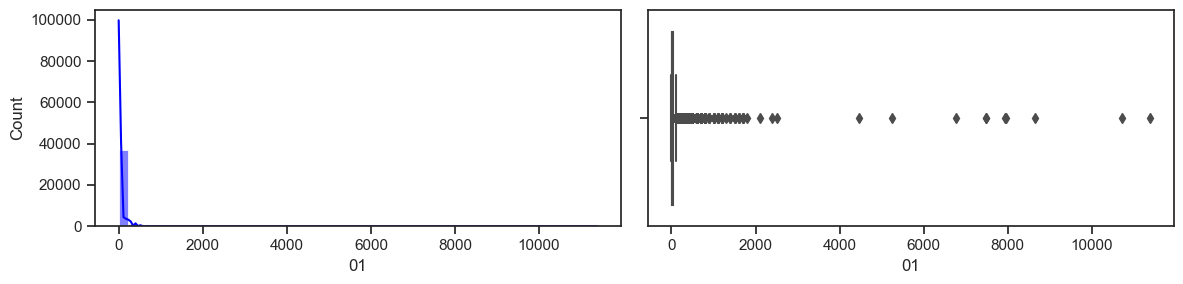

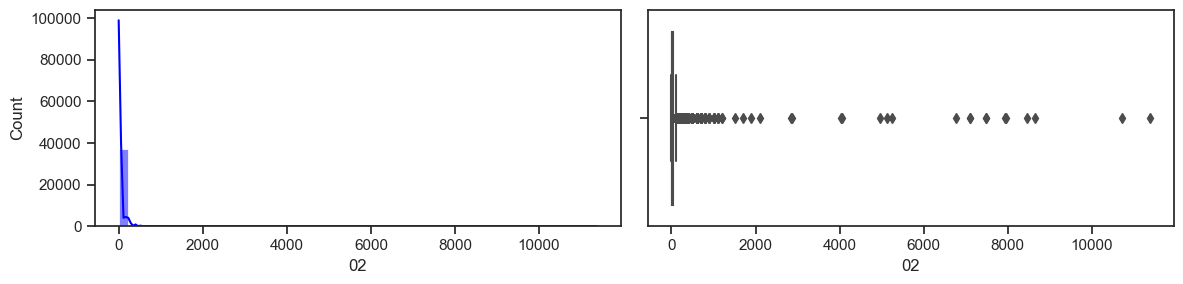

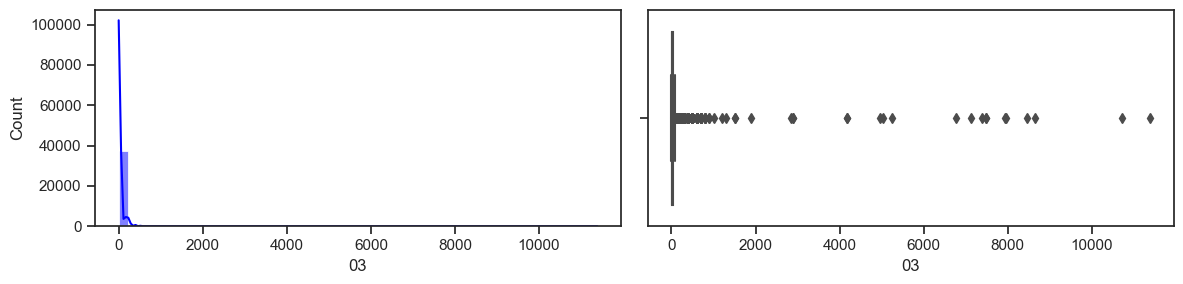

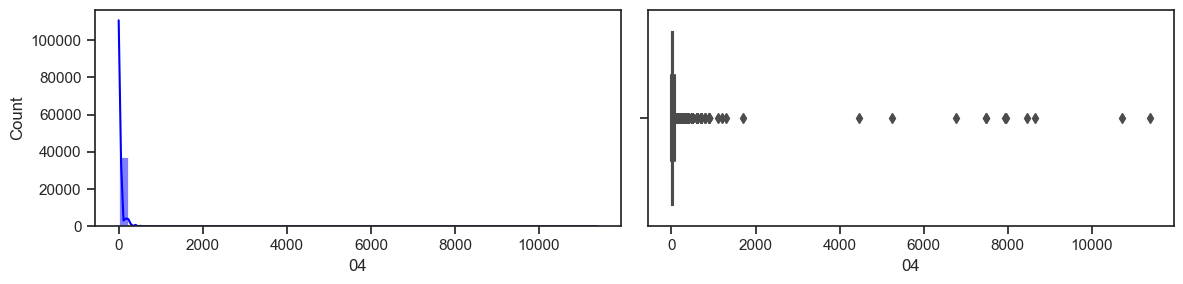

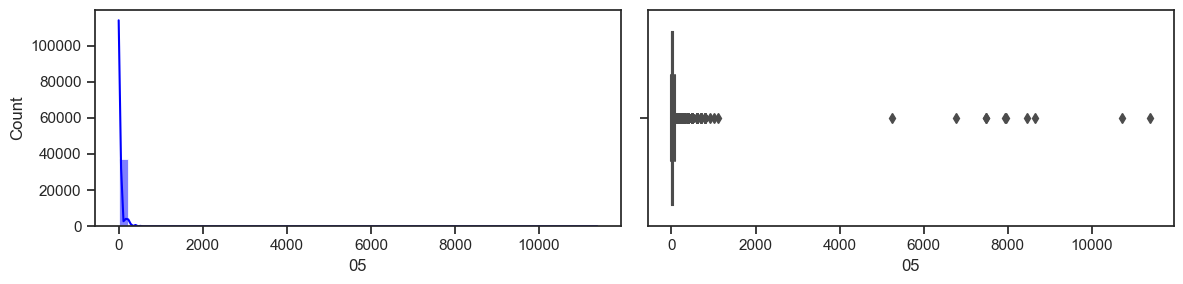

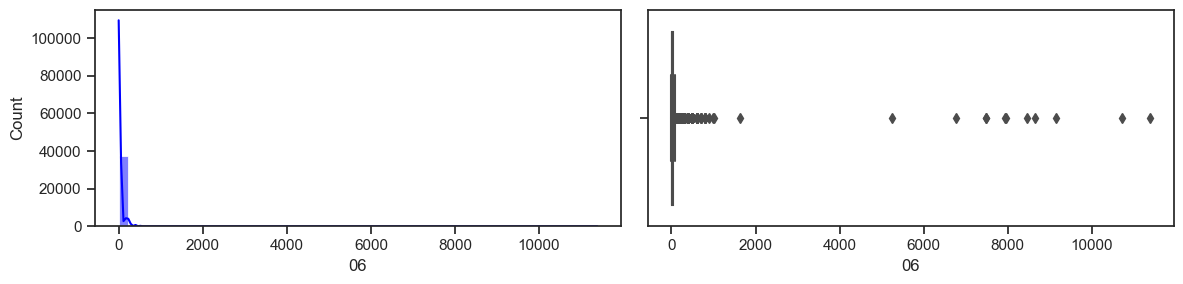

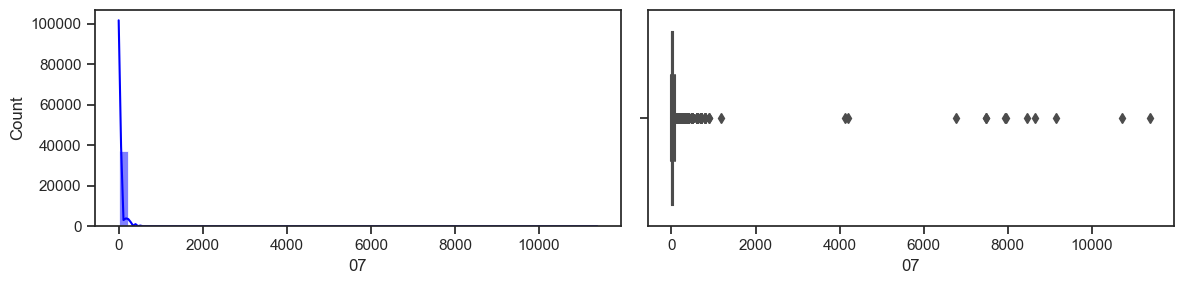

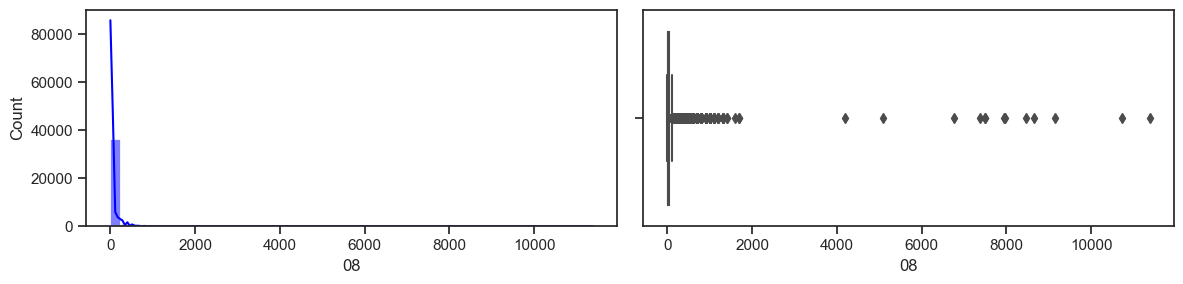

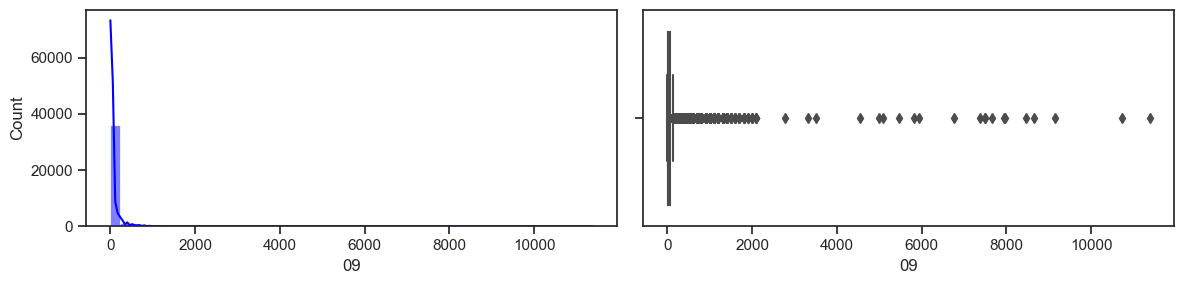

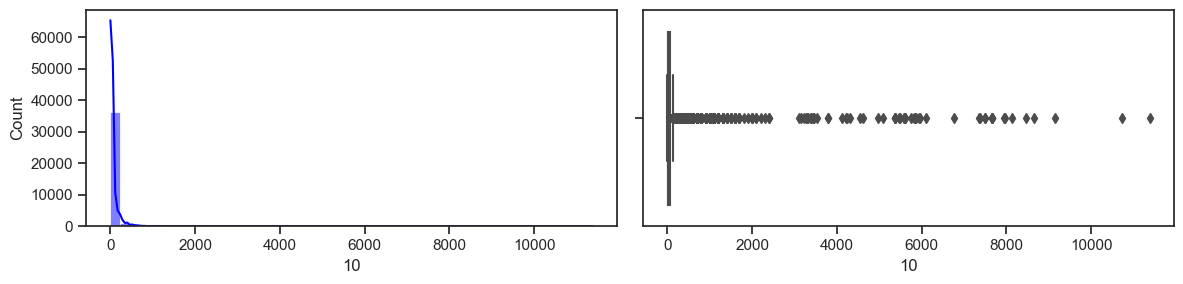

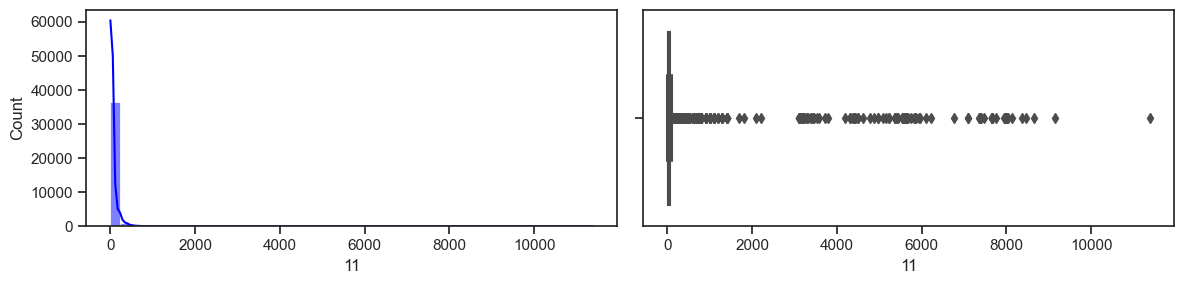

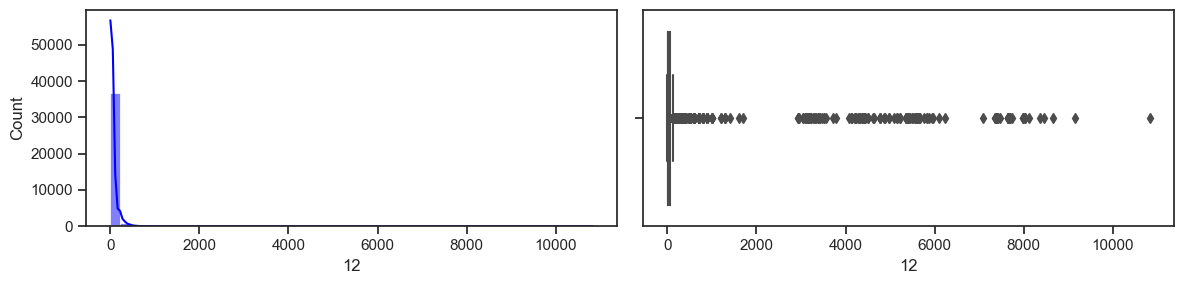

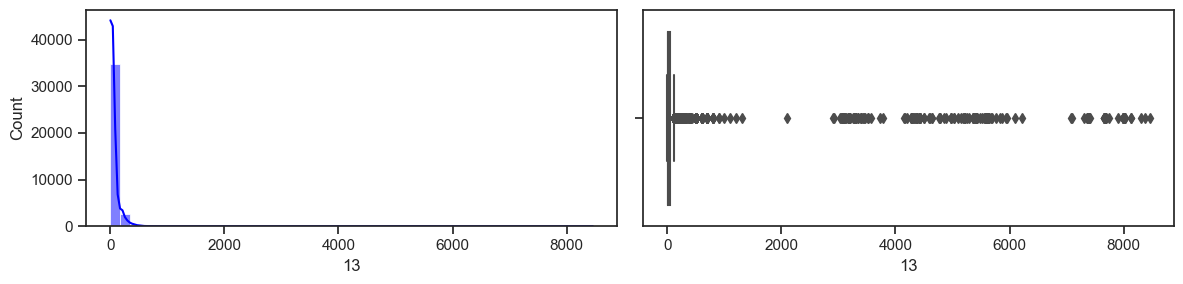

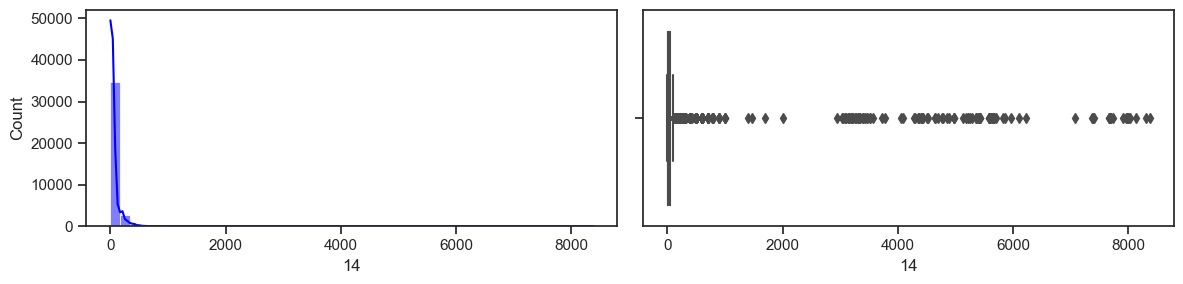

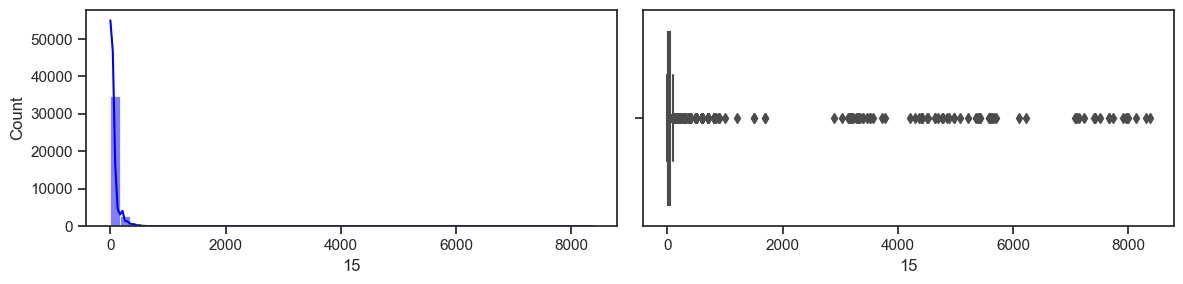

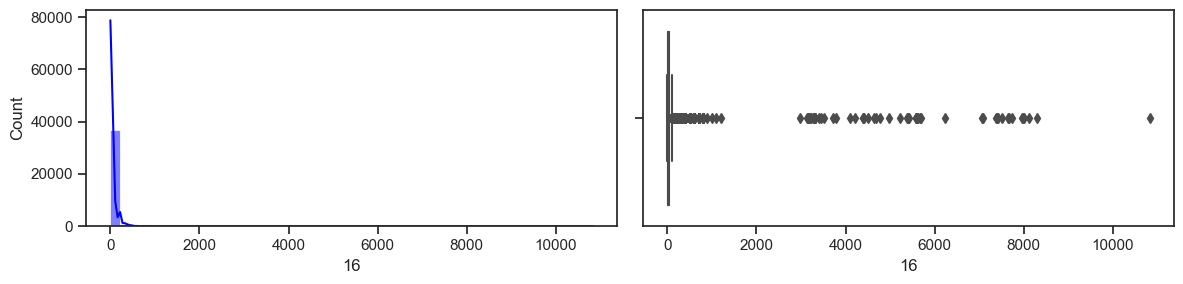

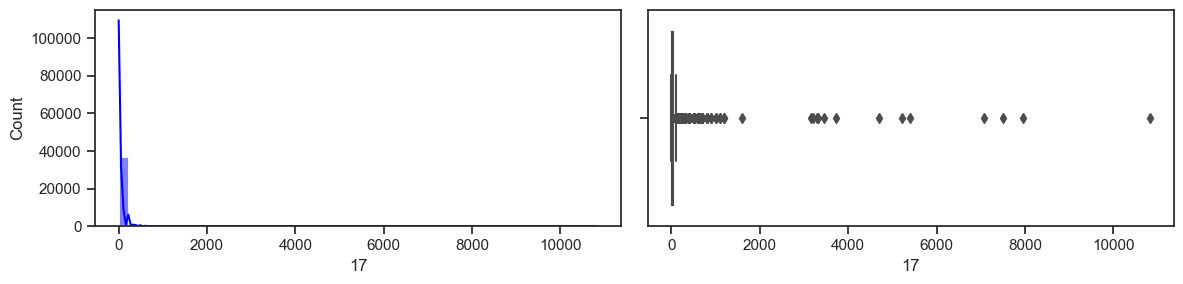

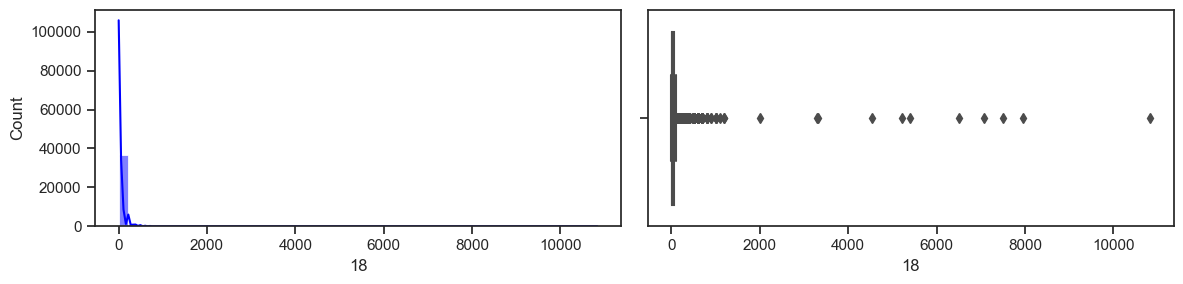

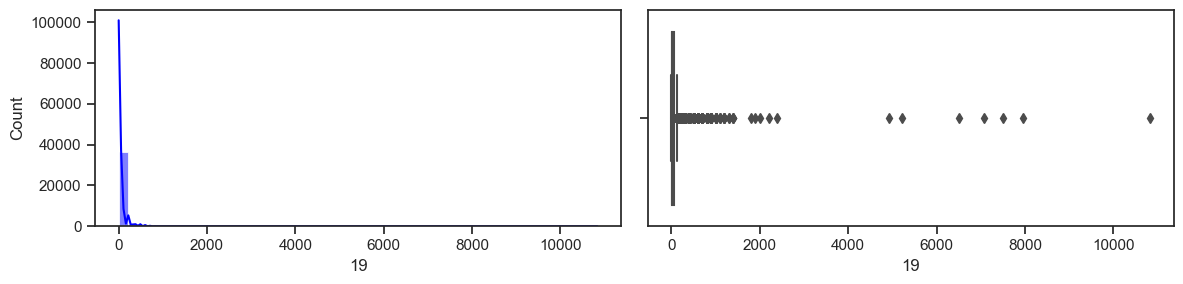

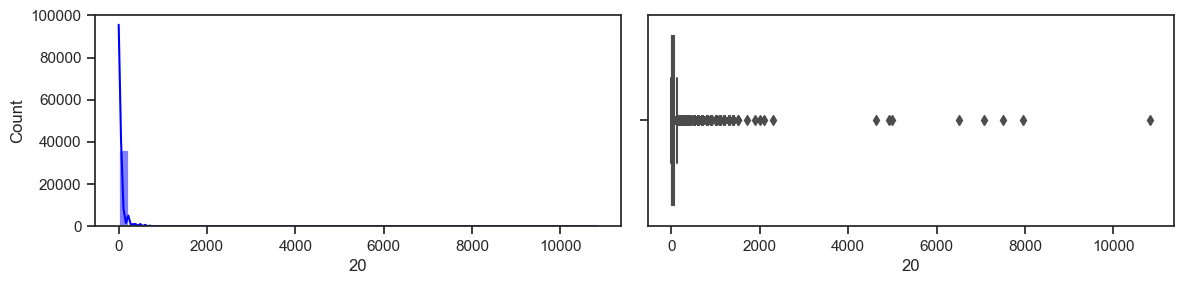

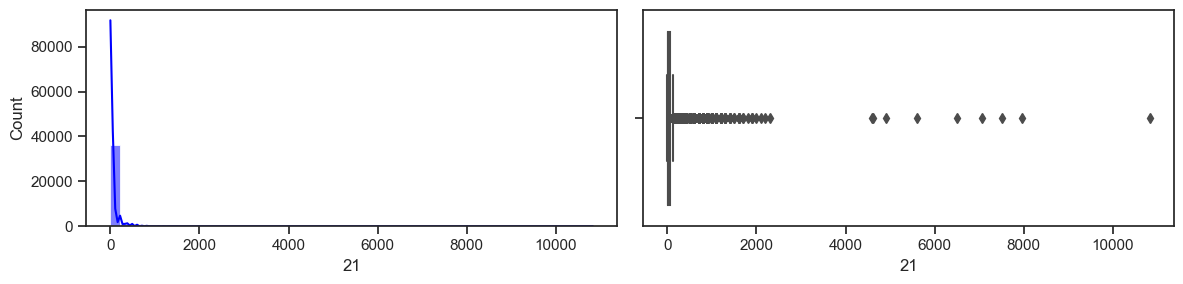

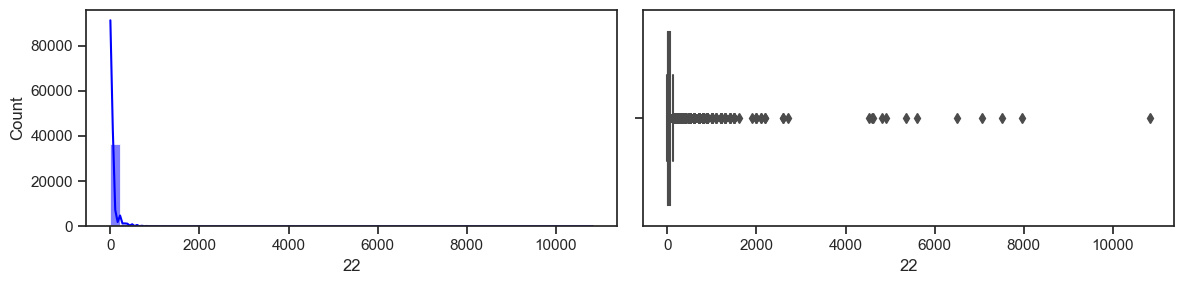

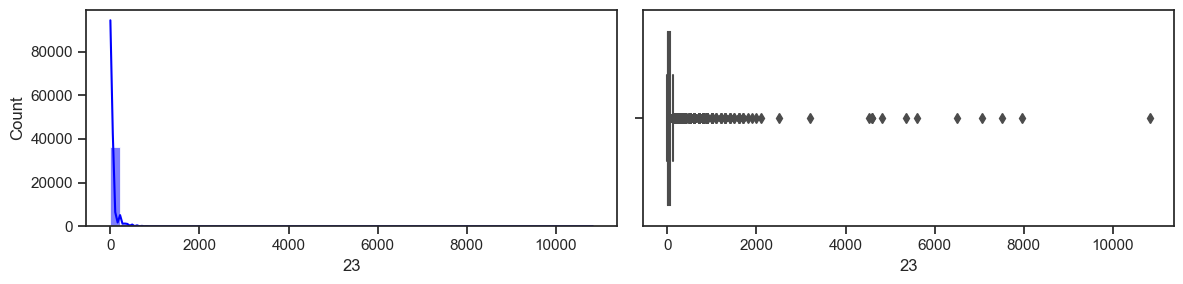

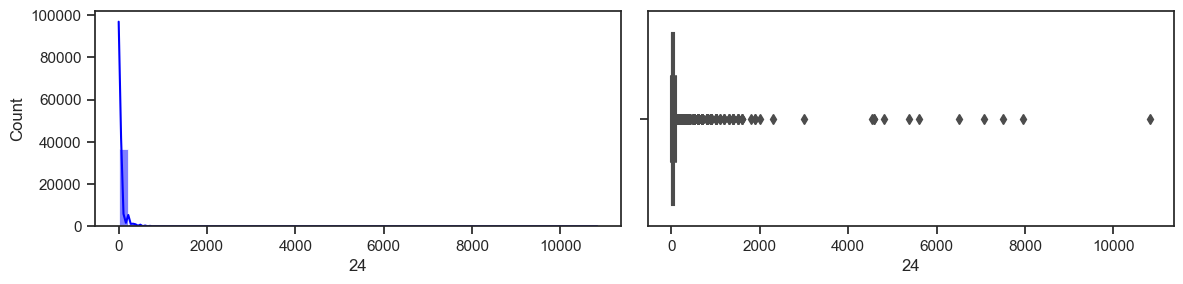

In [389]:
dist (x_num)

### Removing outliers could have a significant impact on the dataset, so I will handle the data by applying a logarithmic transformation.

Numerical columns are highly skewed (positive skewness).

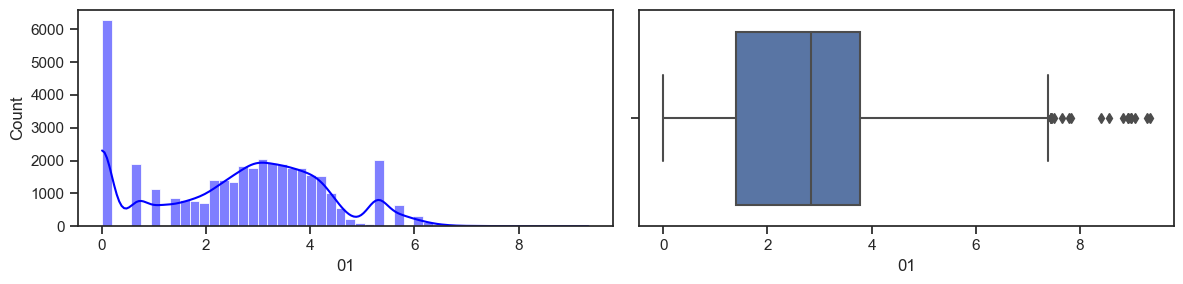

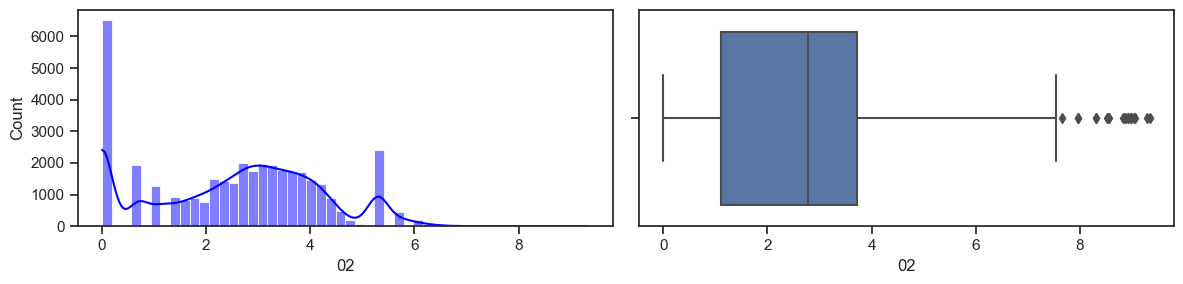

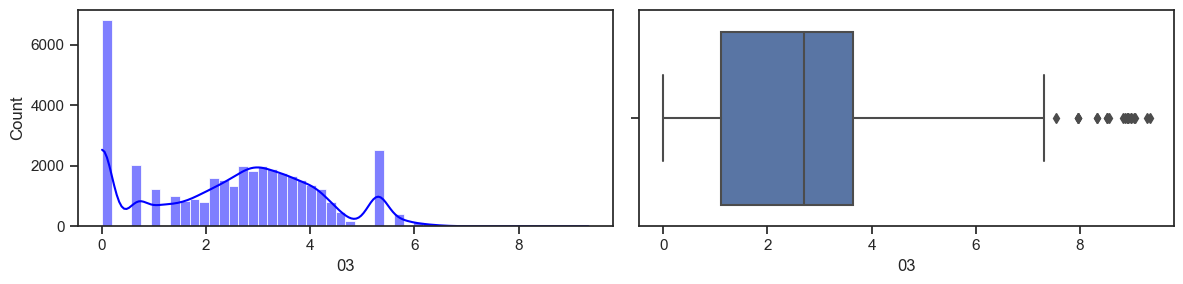

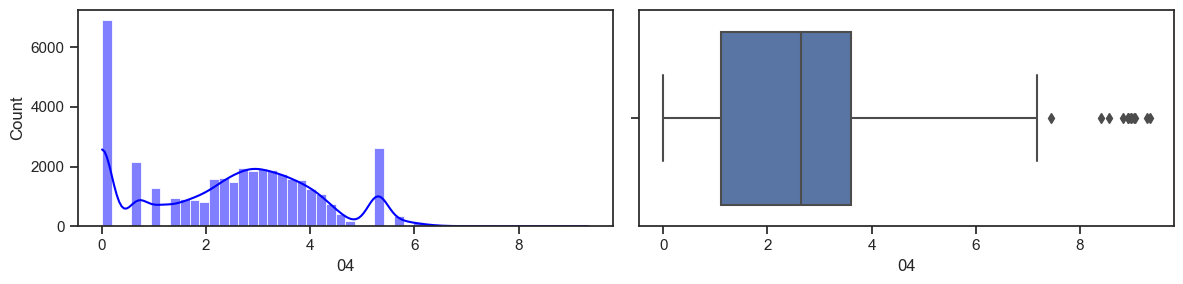

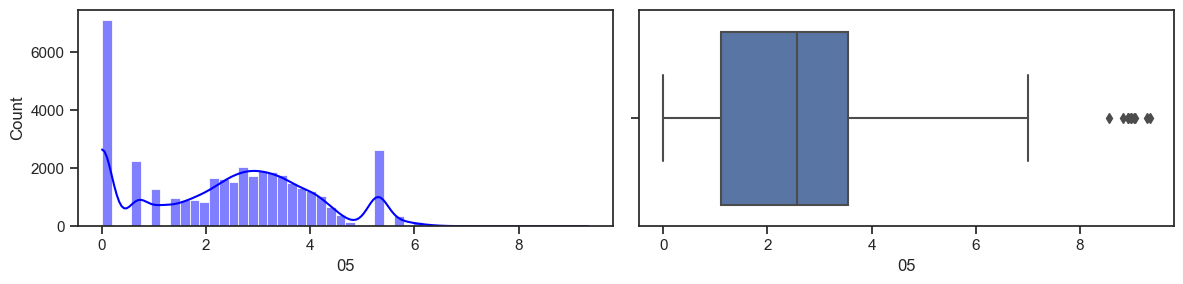

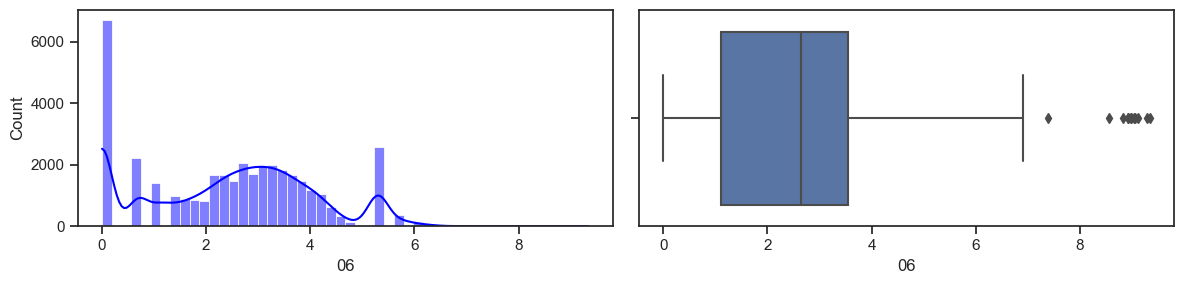

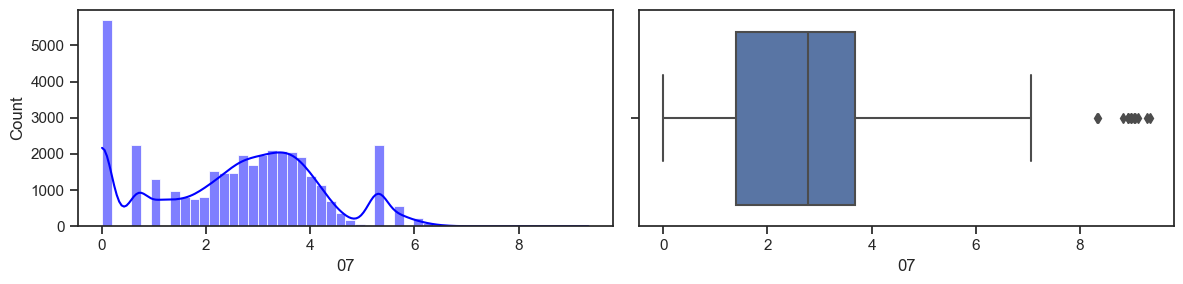

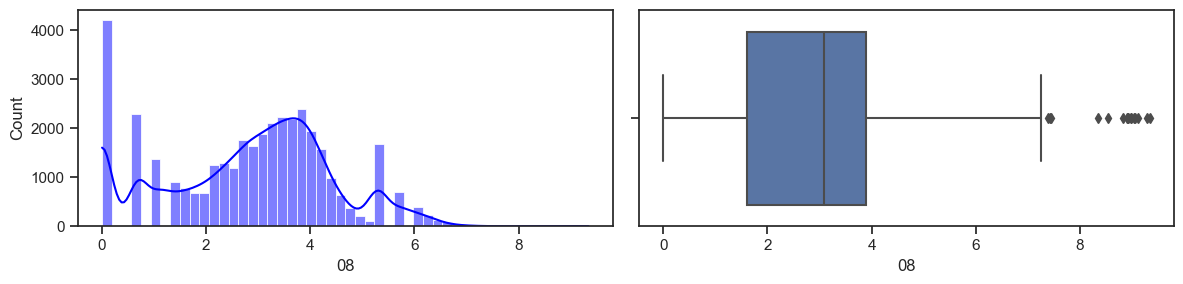

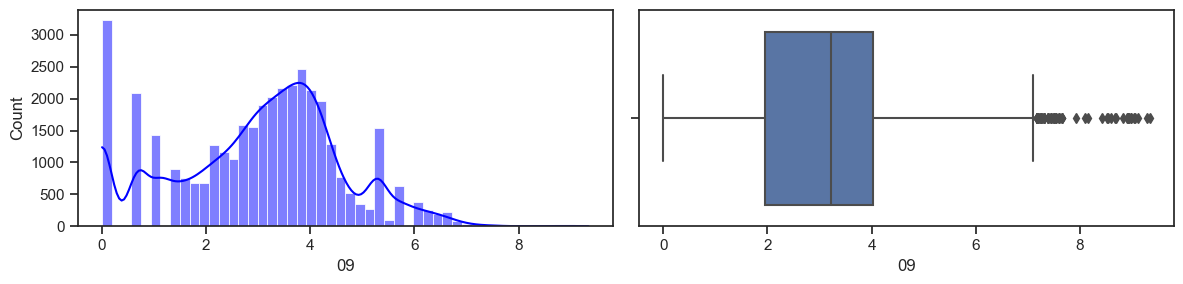

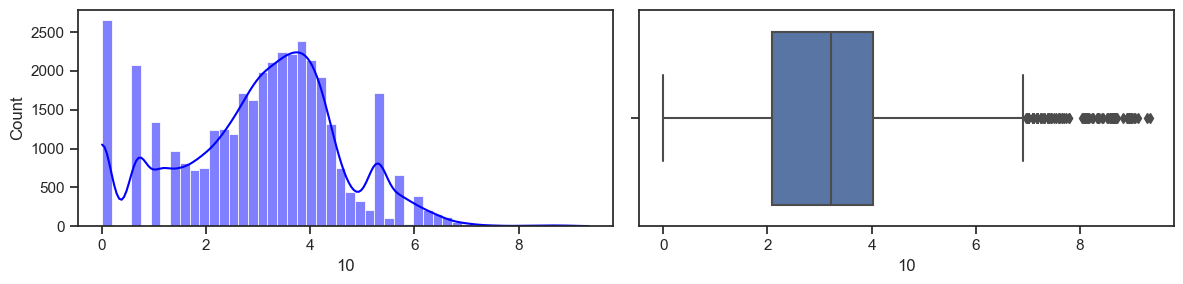

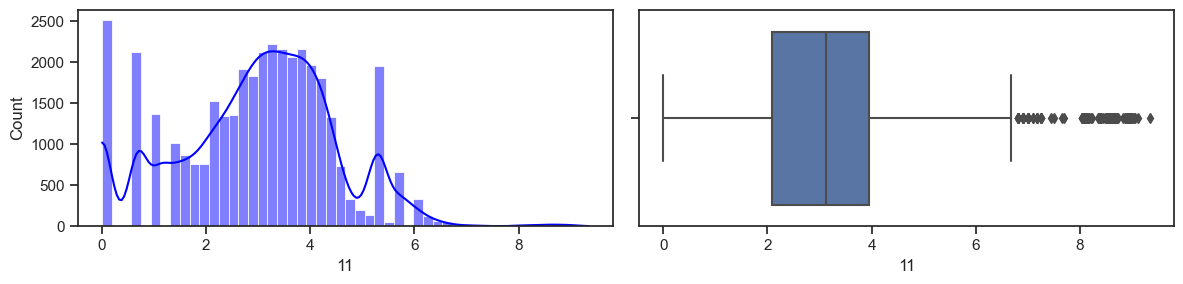

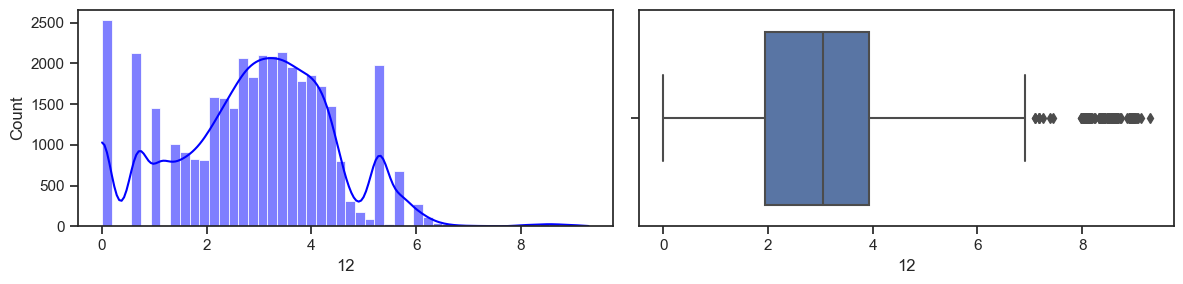

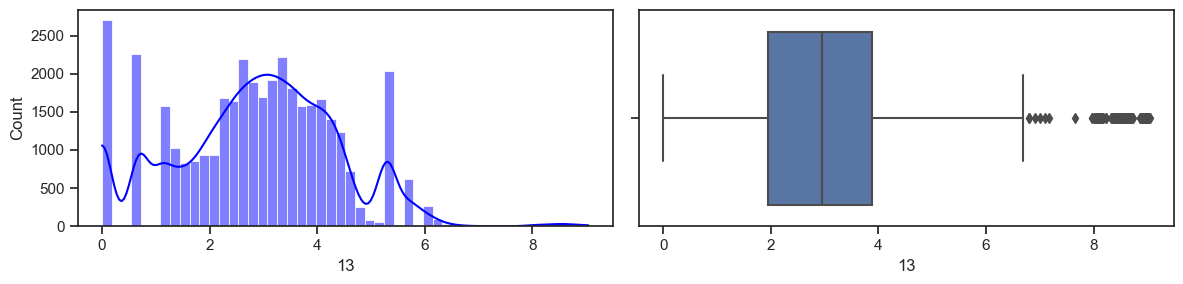

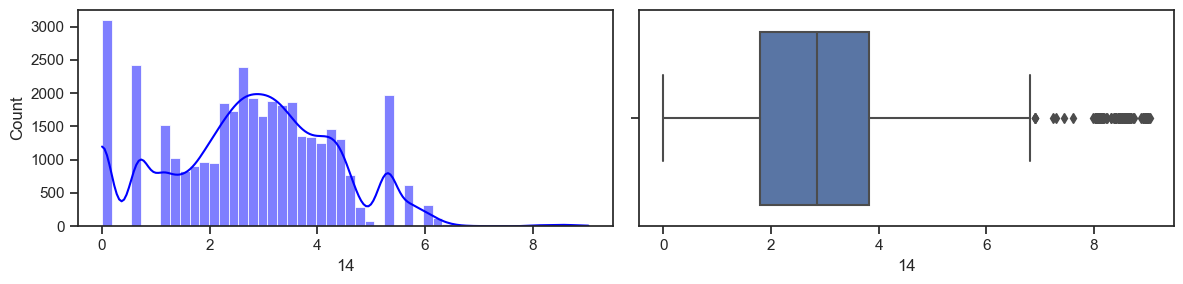

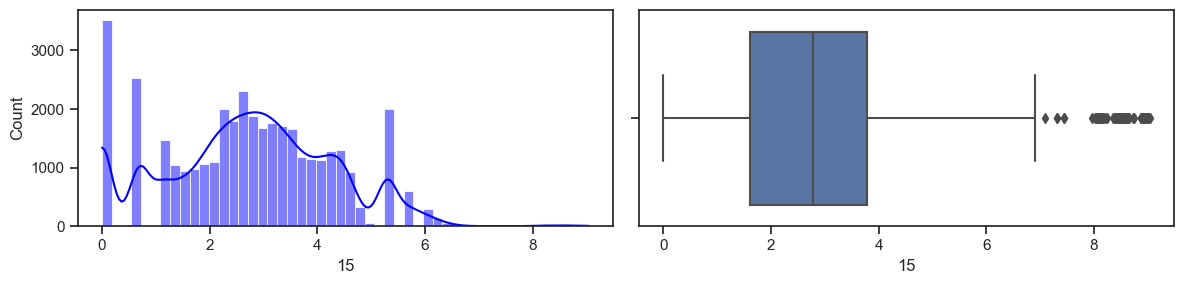

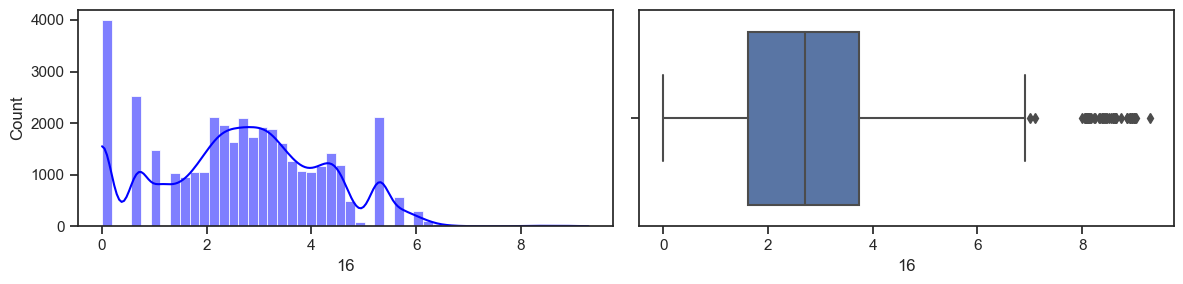

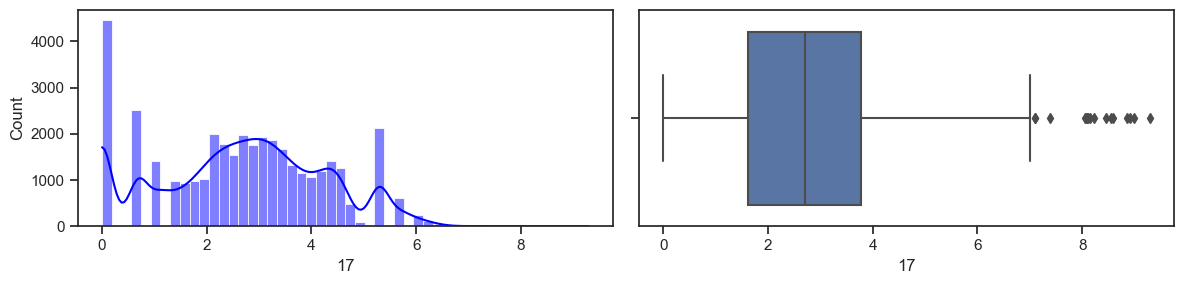

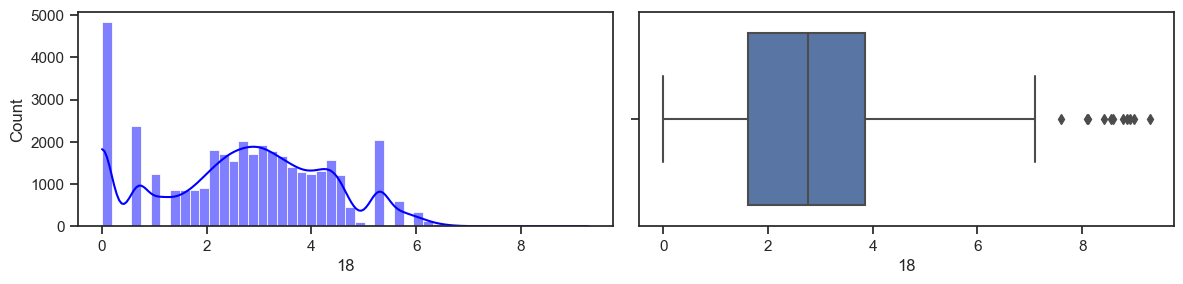

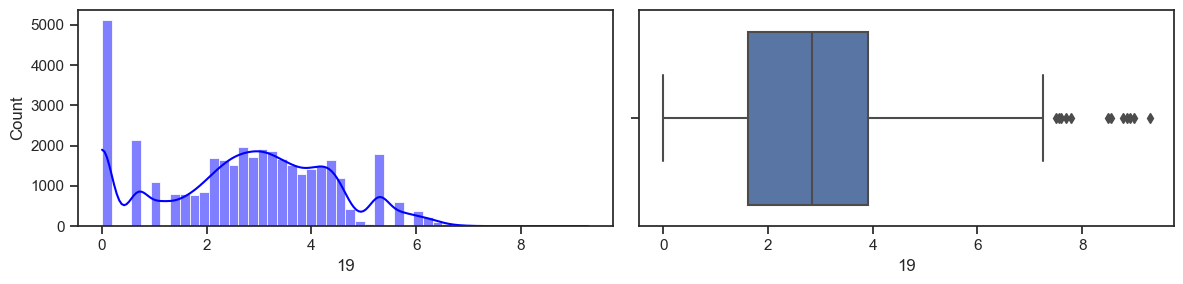

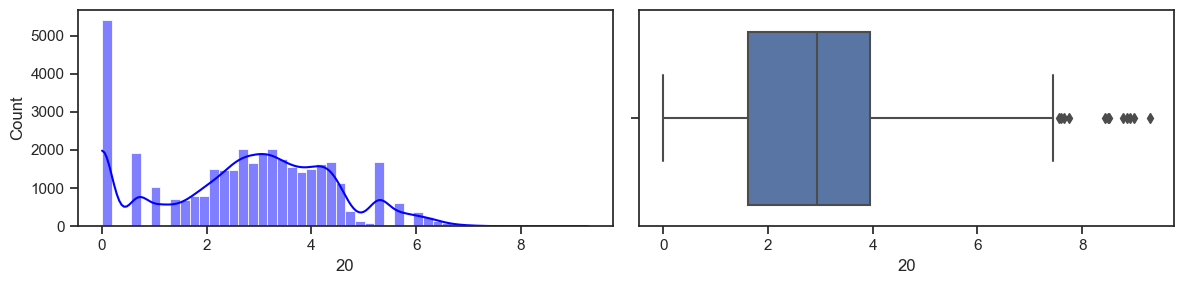

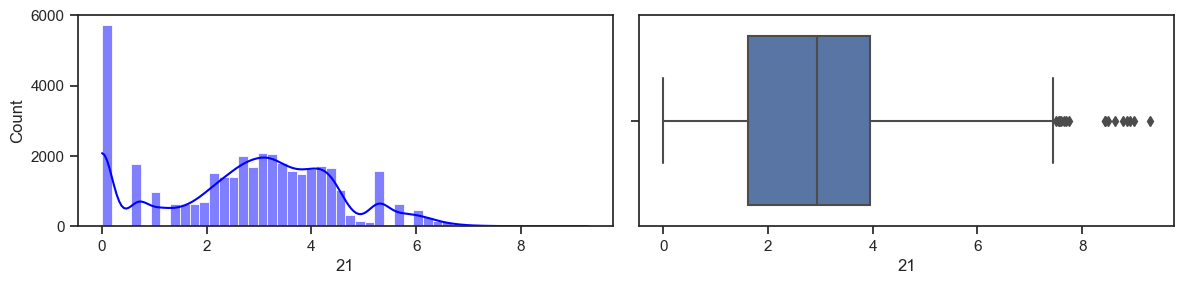

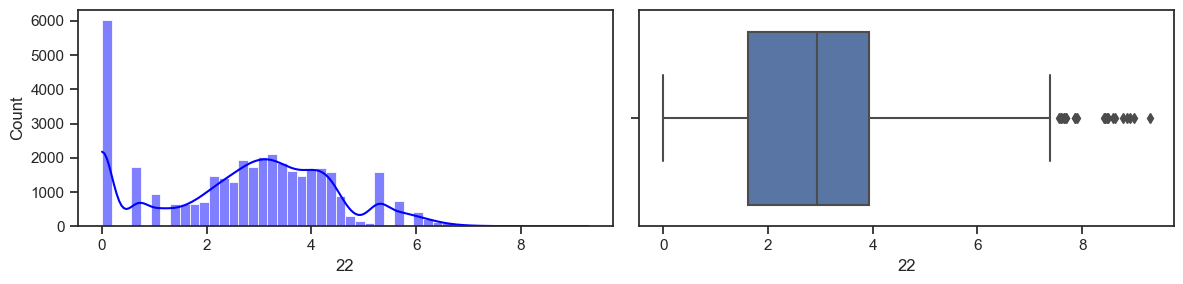

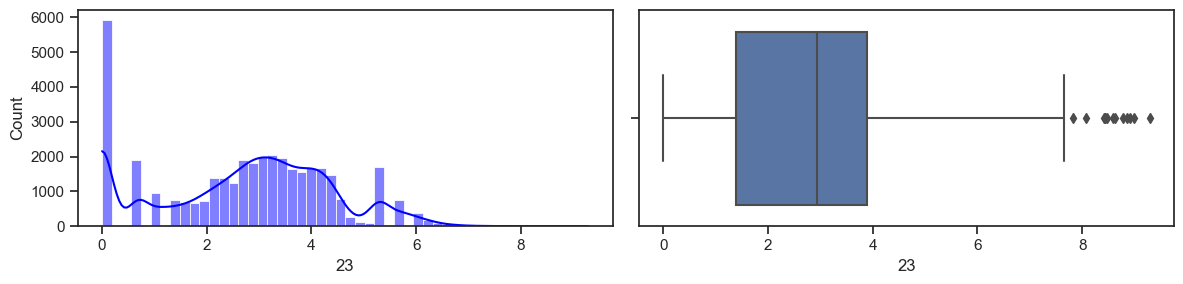

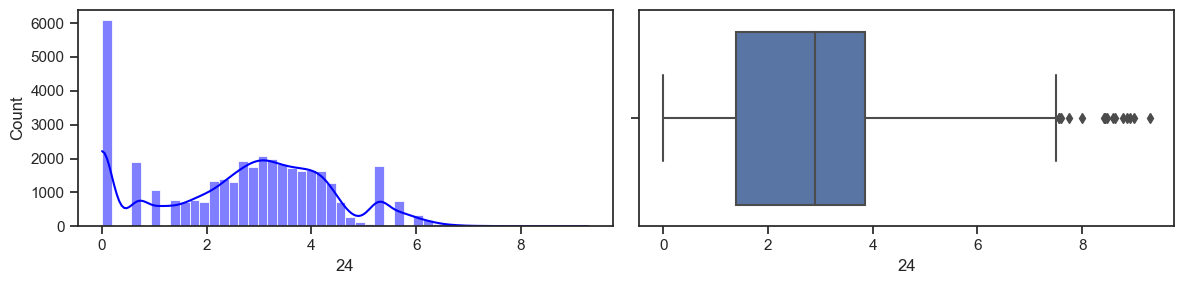

In [390]:
# I will apply a logarithmic transformation to adjust the skewness.
for i in x_num.columns:
    # Use log transformation to replace the values of the column now
    x_num[i] = list(map(log_transfom_clean, x_num[i]))
    x_num[i] = x_num[i].fillna(np.mean(x_num[i]))

    # Crea dos gráficos de Seaborn
    plt.figure(figsize=(12, 3))  # Tamaño de la figura
    
    # Primer gráfico
    plt.subplot(1, 2, 1)  
    sns.histplot(x_num[i], bins = 50, kde = True, color = 'blue')

    # Segundo gráfico
    plt.subplot(1, 2, 2)  
    sns.boxplot(x = x_num[i])

    plt.tight_layout()  # Ajusta el diseño para evitar superposiciones
    plt.show()  # Muestra la figura


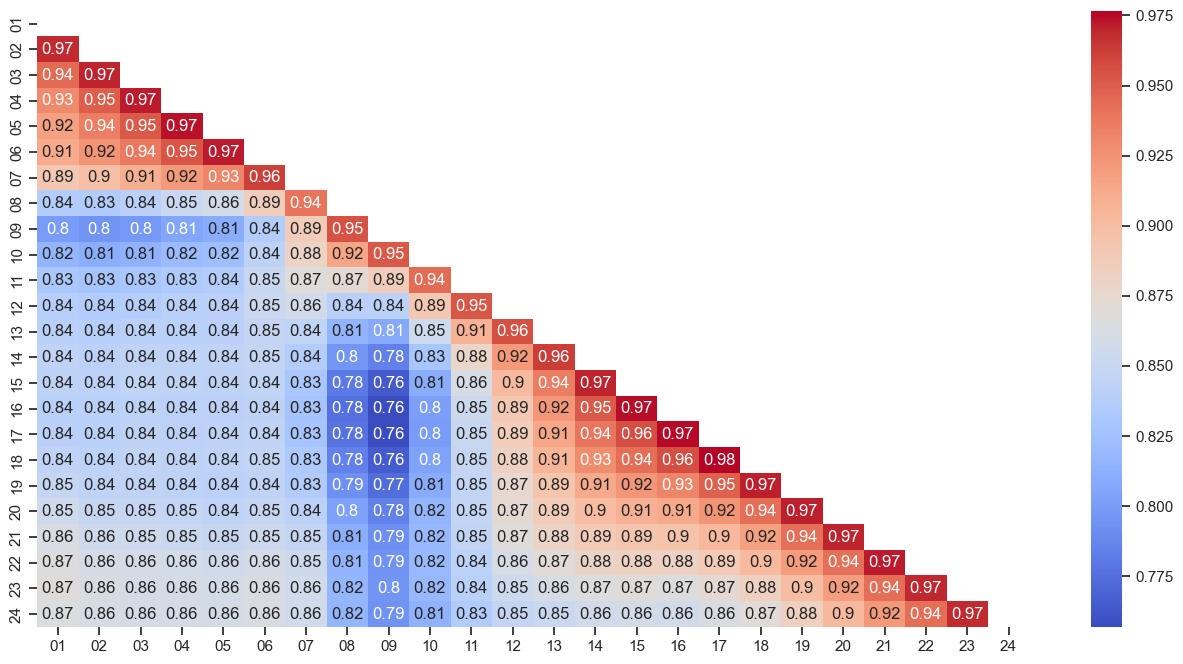

In [391]:
# Check for correlations

df_num = x_num.corr()
mask = np.zeros_like(df_num)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.heatmap(df_num, mask=mask, annot=True, cmap = 'coolwarm')
plt.show()

Seeing that there is a strong correlation between continuous hours, and considering that the World Health Organization considers the effects of air pollutants present for more than 8 hours to be harmful, I will stick with 3 time slots: 01, 09, and 17 hours.

In [392]:
x_num

,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.386294,1.098612,1.098612,1.609438,0.693147,0.693147,0.693147,1.098612,2.197225,1.791759,1.945910,1.791759,2.079442,2.484907,1.945910,2.197225,1.791759,1.791759,1.791759,1.609438,1.609438,0.693147,0.693147,0.693147
1,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,1.098612,3.178054,3.891820,3.737670,3.583519,3.044522,2.079442,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.639057,2.833213,3.044522,2.995732,3.135494,2.833213,2.708050,3.433987,4.025352,3.401197,2.197225,2.484907,2.772589,2.079442,1.945910,2.079442,1.945910,2.079442,2.302585,2.564949,3.091042,2.995732,2.708050,2.944439
3,2.564949,2.708050,2.484907,2.079442,2.708050,2.995732,2.944439,3.178054,3.583519,3.367296,2.564949,3.178054,3.610918,3.218876,3.178054,2.944439,3.295837,3.135494,3.465736,3.135494,3.178054,2.639057,2.890372,2.944439
4,3.806662,3.784190,3.555348,3.761200,3.433987,3.258097,3.091042,3.637586,4.077537,3.806662,3.761200,3.637586,3.784190,3.951244,3.637586,3.784190,3.610918,3.610918,3.737670,3.610918,3.688879,3.367296,3.135494,3.178054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37980,3.555348,3.526361,3.295837,3.178054,3.332205,3.663562,4.025352,4.043051,4.454347,4.454347,4.290459,4.262680,3.891820,3.583519,2.944439,2.833213,3.091042,2.833213,3.295837,3.135494,2.833213,2.890372,3.526361,3.555348
37981,3.496508,3.295837,3.135494,3.218876,2.639057,2.639057,3.433987,5.420535,4.882802,4.804021,4.317488,3.988984,3.496508,3.367296,3.496508,3.332205,3.401197,3.610918,3.688879,3.951244,3.583519,2.890372,3.178054,3.401197
37982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
37983,1.609438,1.791759,2.833213,2.564949,1.098612,2.639057,2.944439,3.433987,3.555348,3.401197,3.850148,3.688879,3.526361,3.044522,3.178054,2.890372,3.367296,3.367296,2.772589,3.218876,3.526361,3.091042,3.178054,2.708050


In [393]:
x_num = x_num.drop (columns = ['02', '03', '04', '05', '06', '07', '08', '10', '11', '12', '13', '14', '15', '16', '18', '19', '20', '21', '22', '23', '24'], axis = 1)

In [394]:
x_num.columns

Index(['01', '09', '17'], dtype='object')

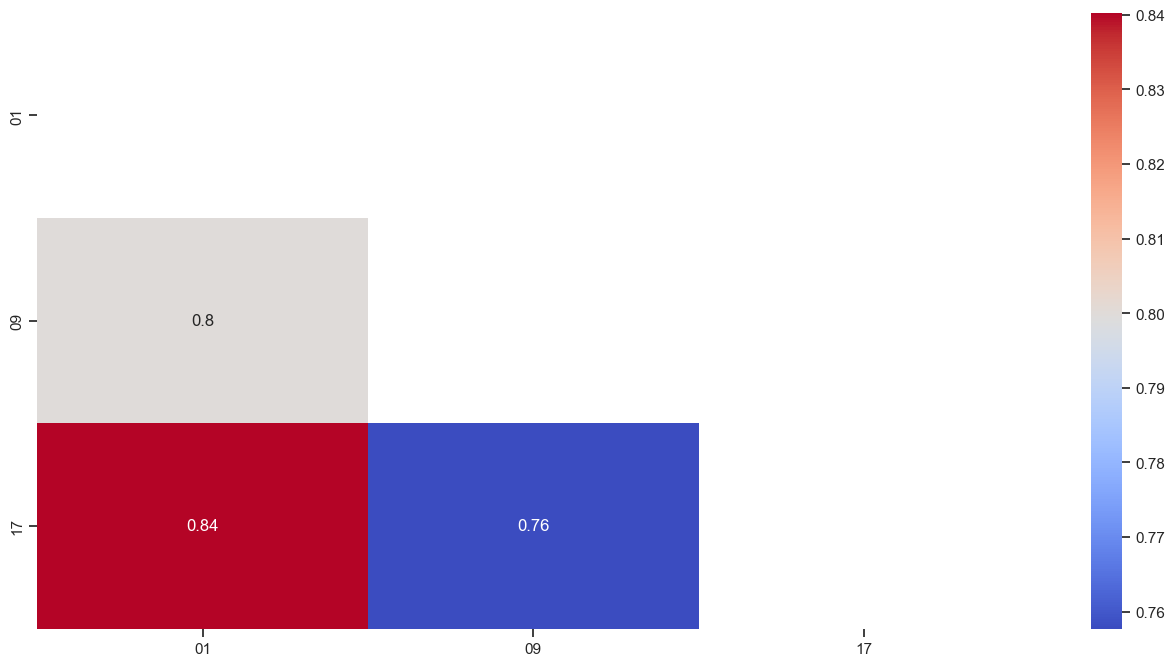

In [395]:
df_num = x_num.corr()
mask = np.zeros_like(df_num)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.heatmap(df_num, mask=mask, annot=True, cmap = 'coolwarm')
plt.show()

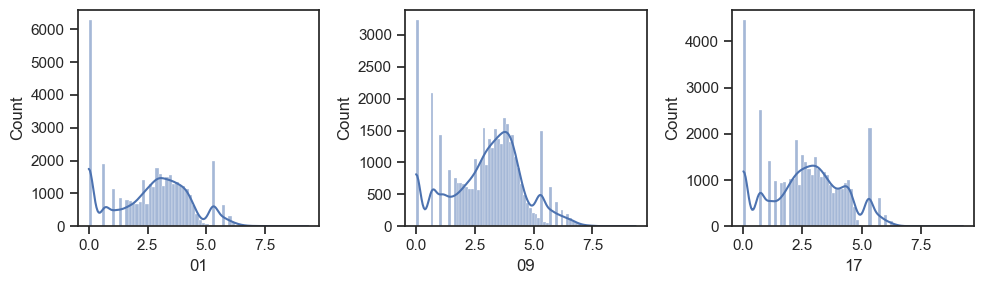

In [396]:
columnas = ['01', '09', '17']

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes = axes.flatten()  # Convertir la matriz 2D de ejes en una lista plana

for i,col in enumerate (columnas):
    sns.histplot(x_num[col], kde=True, ax=axes[i])

plt.tight_layout()
plt.show()

### DISTRICT

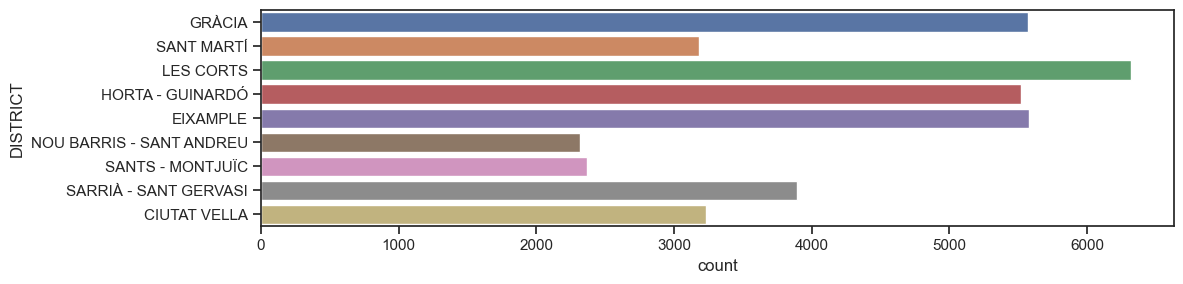

Value counts
LES CORTS                   6317
EIXAMPLE                    5582
GRÀCIA                      5570
HORTA - GUINARDÓ            5519
SARRIÀ - SANT GERVASI       3893
CIUTAT VELLA                3234
SANT MARTÍ                  3180
SANTS - MONTJUÏC            2370
NOU BARRIS - SANT ANDREU    2320
Name: DISTRICT, dtype: int64
_______________________________


In [397]:
sns.set(style="ticks")
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(12, 3))

# Creación de gráfico
sns.countplot(data= df, y = df['DISTRICT'], ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()
print ('Value counts')
print (df['DISTRICT'].value_counts())
print ('_______________________________')

plt.show()

In [398]:
df.columns

Index(['DISTRICT', 'DATE', 'POLLULLANT', 'TYPE', 'URBAN_AREA', '01', '02',
       '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', 'RATIO',
       'ID', 'Status'],
      dtype='object')

### DATE DATA

In [399]:
df.groupby ('DATE')['DATE'].value_counts ().describe ()

count    811.000000
mean      46.837238
std        2.558577
min        5.000000
25%       46.000000
50%       48.000000
75%       48.000000
max       49.000000
Name: DATE, dtype: float64

### POLLULLANT

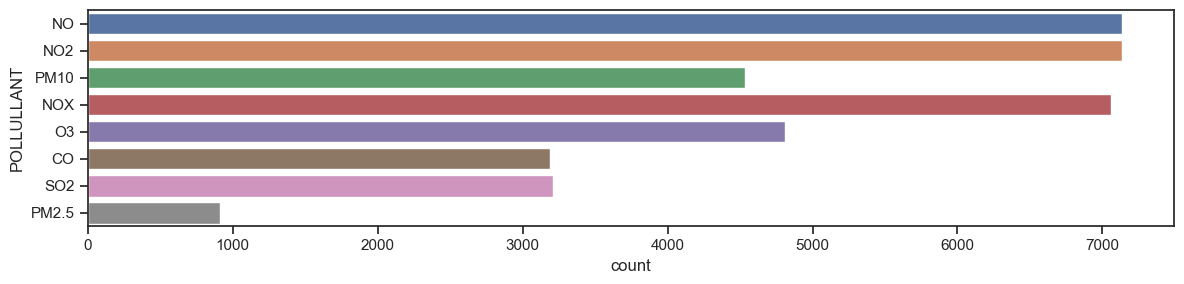

Value counts
NO       7137
NO2      7137
NOX      7058
O3       4809
PM10     4531
SO2      3212
CO       3190
PM2.5     911
Name: POLLULLANT, dtype: int64
_______________________________


In [400]:
sns.set(style="ticks")
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(12, 3))

# Creación de gráfico
sns.countplot(data= df, y = df['POLLULLANT'], ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()
print ('Value counts')
print (df['POLLULLANT'].value_counts())
print ('_______________________________')

plt.show()

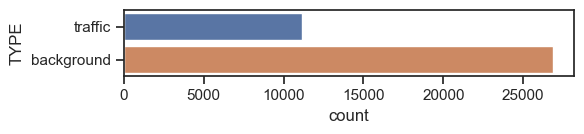

Value counts
background    26833
traffic       11152
Name: TYPE, dtype: int64
_______________________________


In [401]:
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(6, 1.5))

# Creación de gráfico
sns.countplot(data= df, y = df['TYPE'], ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()
print ('Value counts')
print (df['TYPE'].value_counts())
print ('_______________________________')

plt.show()

### URBAN AREA

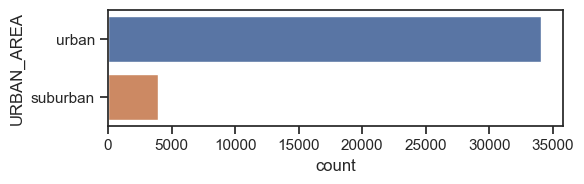

Value counts
urban       34092
suburban     3893
Name: URBAN_AREA, dtype: int64
_______________________________


In [402]:
sns.set(style="ticks")
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(6, 2))

# Creación de gráfico
sns.countplot(data= df, y = df['URBAN_AREA'], ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()
print ('Value counts')
print (df['URBAN_AREA'].value_counts())
print ('_______________________________')

plt.show()

### Air Quality Status

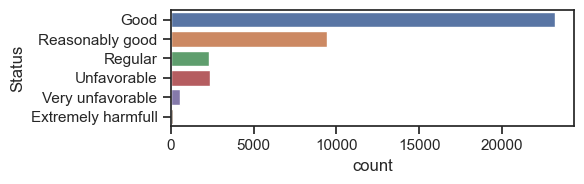

Value counts
Good                  23194
Reasonably good        9452
Unfavorable            2367
Regular                2289
Very unfavorable        535
Extremely harmfull      148
Name: Status, dtype: int64
_______________________________


In [403]:
sns.set(style="ticks")
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(6, 2))

# Creación de gráfico
sns.countplot(data= df, y = df['Status'], ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()
print ('Value counts')
print (df['Status'].value_counts())
print ('_______________________________')

plt.show()

In [404]:
cols = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']

In [405]:
df.to_csv ('export_to_tableau.csv', index = False)

### LOGISTIC REGRESSION (IMBALANCED DATA) - Multiclass prediction: Good, Reasonably good, Unfavorable, Regular, Very unfavorable, Extremely harmfull.

# Pre-processing

Numerical (Normalized)

In [406]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the numeric columns and replace the original values
x = scaler.fit_transform(x_num)

x

array([[-0.74125796, -0.5047874 , -0.54472509],
       [-1.15601142,  0.55306257, -1.66927735],
       [ 0.00834875,  0.63641943, -0.44797633],
       ...,
       [-1.57076488, -1.87640302, -1.66927735],
       [-0.60773717,  0.34302005,  0.44412024],
       [ 1.59955093,  1.86376375,  1.6560768 ]])

Categorical

In [407]:
cat = df.select_dtypes(include = object)
cat = cat.drop(['Status'], axis=1)
categorical = pd.get_dummies(cat, columns=['DISTRICT', 'POLLULLANT', 'TYPE', 'URBAN_AREA', 'RATIO', 'ID'])

### Train test split

In [408]:
y = df['Status']
X = np.concatenate((x, categorical), axis=1)

In [409]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

### Modelling

In [410]:
classification = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
classification.fit (X_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

In [411]:
# Predictions over the test set
predictions = classification.predict(X_test)

classification.score (X_test, y_test)

0.8448071607213373

### Model Accuracy

Test

In [412]:
y_test.value_counts()

Good                  9249
Reasonably good       3791
Unfavorable            966
Regular                909
Very unfavorable       222
Extremely harmfull      57
Name: Status, dtype: int64

Prediction

In [413]:
pd.Series(predictions).value_counts()

Good                  9234
Reasonably good       4419
Unfavorable           1147
Regular                304
Very unfavorable        88
Extremely harmfull       2
dtype: int64

Confusion Matrix

In [414]:
confusion_matrix(y_test, predictions)

array([[   1,    0,    0,    2,    8,   46],
       [   1, 8714,  523,    1,    8,    2],
       [   0,  482, 3211,   35,   63,    0],
       [   0,   34,  528,  155,  192,    0],
       [   0,    4,  155,   92,  715,    0],
       [   0,    0,    2,   19,  161,   40]])

In [415]:
classification.predict_proba(X_test)

array([[4.41167270e-09, 9.97171727e-01, 2.81594832e-03, 1.21612659e-05,
        1.57347324e-07, 2.02150401e-09],
       [2.44010331e-05, 1.16062024e-02, 7.02777744e-01, 1.98570498e-01,
        8.67429917e-02, 2.78163024e-04],
       [3.71759681e-09, 8.35484436e-01, 1.62688486e-01, 1.75915057e-03,
        6.78418089e-05, 8.20496380e-08],
       ...,
       [1.51708047e-22, 9.99999600e-01, 3.99876379e-07, 8.79968291e-14,
        3.72076947e-18, 3.27203308e-23],
       [2.07197216e-20, 9.99999948e-01, 5.16097396e-08, 2.32341793e-12,
        8.25530271e-16, 1.13951354e-19],
       [4.52466604e-05, 1.41876490e-01, 7.90301519e-01, 5.61266573e-02,
        1.14938680e-02, 1.56218952e-04]])

### I will divide the status into acceptable or not acceptable air quality.

In [416]:
df = df
df ['binary_status'] = None

In [417]:
def binary_status (x):
    if 'Extremely harmfull' in x:
        return 0
    if 'Very unfavorable' in x:
        return 0
    if 'Unfavorable' in x:
        return 0
    if 'Regular' in x:
        return 1
    if 'Reasonably good' in x:
        return 1
    if 'Good' in x:
        return 1
    else:
        return x

In [418]:
df['binary_status'] = list(map(binary_status, df['Status']))

In [419]:
df['binary_status'].value_counts ()

1    34935
0     3050
Name: binary_status, dtype: int64

### LOGISTIC REGRESSION (IMBALANCED DATA) - Binary prediction: Acceptable or Not Acceptable

### Preprocessing

Numerical Data

In [420]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the numeric columns and replace the original values
x = scaler.fit_transform(x_num)

x

array([[-0.74125796, -0.5047874 , -0.54472509],
       [-1.15601142,  0.55306257, -1.66927735],
       [ 0.00834875,  0.63641943, -0.44797633],
       ...,
       [-1.57076488, -1.87640302, -1.66927735],
       [-0.60773717,  0.34302005,  0.44412024],
       [ 1.59955093,  1.86376375,  1.6560768 ]])

Categorical Cata

In [421]:
cat = df.select_dtypes(include = object)
cat = cat.drop(['Status'], axis=1)
categorical = pd.get_dummies(cat, columns=['DISTRICT', 'POLLULLANT', 'TYPE', 'URBAN_AREA', 'RATIO', 'ID'])

Train Test

In [422]:
y = df['binary_status']
X = np.concatenate((x, categorical), axis=1)

In [423]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Modelling

In [424]:
classification = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
classification.fit (X_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

Prediction

In [425]:
# Predictions over the test set
predictions = classification.predict(X_test)

classification.score (X_test, y_test)

0.9698565223114387

In [426]:
pd.Series(predictions).value_counts()

1    7087
0     510
dtype: int64

In [427]:
# Calculate classification metrics for a binary classification problem
accuracy1 = accuracy_score (y_test, predictions)
precision1 = precision_score (y_test, predictions)
recall1 = recall_score (y_test, predictions)
f1_score1 = f1_score (y_test, predictions)

# Print the metrics
print(f"Accuracy: {accuracy1}")
print(f"Precision: {precision1}")
print(f"Recall: {recall1}")
print(f"F1 Score: {f1_score1}")

Accuracy: 0.9698565223114387
Precision: 0.9765768308169889
Recall: 0.990979381443299
F1 Score: 0.9837253926515528


## Upsamplig using SMOTE

In [428]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [429]:
numerical = df.select_dtypes (include = np.number)
categorical = df.select_dtypes (include = object)

In [430]:
categorical.columns

Index(['DISTRICT', 'POLLULLANT', 'TYPE', 'URBAN_AREA', 'RATIO', 'ID',
       'Status'],
      dtype='object')

### I will first encode the categorical variables.

In [431]:
encoder = OneHotEncoder(drop='first').fit(categorical)
encoded_categorical = encoder.transform(categorical).toarray()
feature_names = encoder.get_feature_names_out(categorical.columns)
encoded_categorical = pd.DataFrame(encoded_categorical, columns = feature_names)

In [432]:
data = pd.concat([numerical, encoded_categorical], axis = 1)

Upsamplig with SMOTE

In [433]:
regression_target = data['binary_status']
data.head()
y = data['binary_status']
X = data.drop(['binary_status'], axis = 1)

In [434]:
smote = SMOTE()
y = data['binary_status']
X = data.drop(['binary_status'], axis=1)
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

1    34935
0    34935
Name: binary_status, dtype: int64

In [435]:
X_sm.shape

(69870, 52)

### LOGISTIC REGRESSION (BALANCED DATA) - Binary prediction: Acceptable or Not Acceptable

In [436]:
y = y_sm
X = X_sm

In [437]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [438]:
classification = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
classification.fit (X_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

In [439]:
# Predictions over the test set
predictions = classification.predict(X_test)

In [440]:
pd.Series(predictions).value_counts()

1    7326
0    6648
dtype: int64

In [441]:
classification.score (X_test, y_test)
confusion_matrix_lr = confusion_matrix(y_test, predictions)

In [442]:

# Calculate classification metrics for a binary classification problem
accuracy2 = accuracy_score (y_test, predictions)
precision2 = precision_score (y_test, predictions)
recall2 = recall_score (y_test, predictions)
f1_score2 = f1_score (y_test, predictions)

# Print the metrics
print(f"Accuracy: {accuracy2}")
print(f"Precision: {precision2}")
print(f"Recall: {recall2}")
print(f"F1 Score: {f1_score2}")

Accuracy: 0.9264348074996422
Precision: 0.9052689052689052
Recall: 0.9520528280218202
F1 Score: 0.9280716484746712


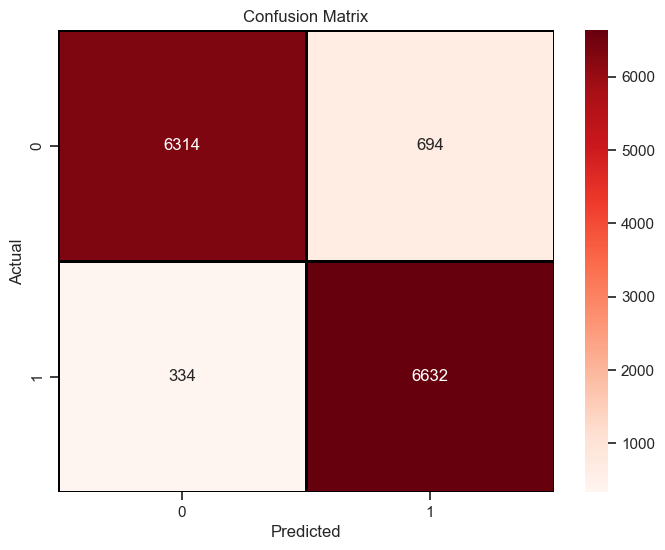

In [443]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_lr, annot=True, fmt='d', cmap='Reds', linewidths=1, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [444]:
# Print the metrics 1 (Data imbalanced) vs 2 (Data Balanced)
print(f'Accuracy: {accuracy1}', f"Accuracy: {accuracy2}")
print(f"Precision: {precision1}", f"Precision: {precision2}")
print(f"Recall: {recall1}", f"Recall: {recall2}")
print(f"F1 Score: {f1_score1}", f"F1 Score: {f1_score2}")

Accuracy: 0.9698565223114387 Accuracy: 0.9264348074996422
Precision: 0.9765768308169889 Precision: 0.9052689052689052
Recall: 0.990979381443299 Recall: 0.9520528280218202
F1 Score: 0.9837253926515528 F1 Score: 0.9280716484746712


### DECISION TREE FOR CATEGORICAL DEPENDENT VARIABLE

In [154]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

In [155]:
# Create and fit the Decision Tree model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [156]:
# Predictions over the test set
y_pred_dt = model.predict(X_test)

# Calculate classification metrics for a binary classification problem
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_score_dt = f1_score(y_test, y_pred_dt)

# Print the metrics
print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1 Score: {f1_score_dt}")

Accuracy: 0.9997137541147846
Precision: 0.9995694603903559
Recall: 0.9998564455928797
F1 Score: 0.9997129323955791


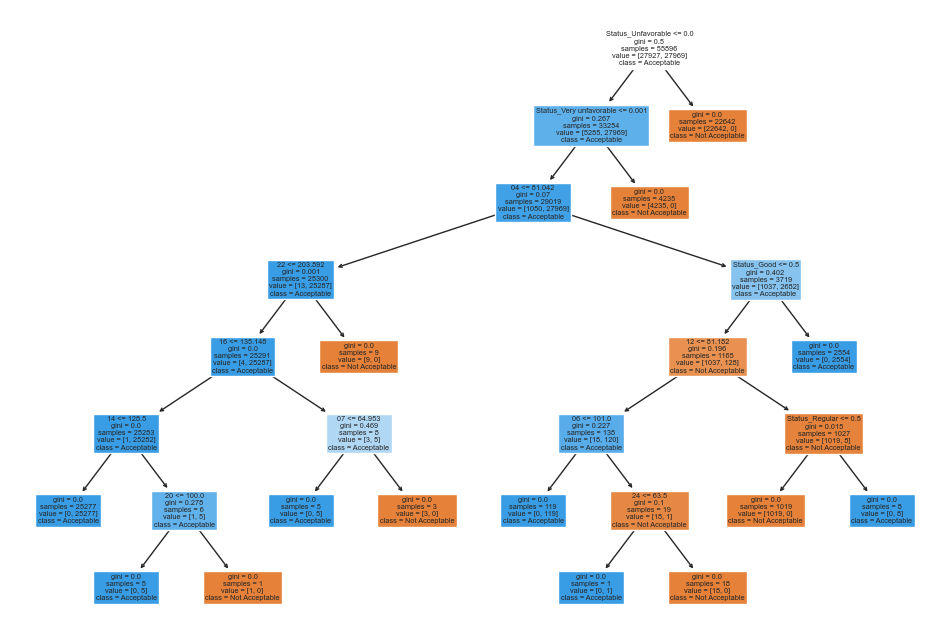

In [157]:
# Plot the decision tree
class_names = ["Not Acceptable", "Acceptable"]  # Replace with your actual class names

plt.figure(figsize=(12, 8))
plot_tree(model, filled=True, feature_names = X_train.columns, class_names=class_names)
plt.show()

# DECISION TREE BEST PARAMETERS

In [ ]:
# Creas un clasificador de árbol de decisión
tree_classifier = DecisionTreeClassifier()

# Defines un rango de valores para los hiperparámetros que elijas
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(tree_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# MEJORES PARÁMETROS
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Training training
best_tree_classifier = DecisionTreeClassifier(**best_params, random_state=42)
best_tree_classifier.fit(X_train, y_train)

In [257]:
best_tree_classifier.score(X_test, y_test)

0.9962788034921998

### RANDOM FOREST IMPLEMENTATION

In [451]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [452]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9388149420352082


In [453]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
cross_val_scores = cross_val_score (clf, X_train, y_train, cv=10)

In [454]:
cross_val_scores

array([0.93685152, 0.93577818, 0.93899821, 0.9411449 , 0.94400716,
       0.94203936, 0.93630345, 0.94435498, 0.94417606, 0.93773484])

In [455]:
np.mean(cross_val_scores)

0.9401388652832312

In [456]:
# Creas un clasificador de rf
rf_classifier = RandomForestClassifier()

# Defines un rango de valores para los hiperparámetros que elijas
param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2,10],
    'max_features': ['auto']
}

grid_search = GridSearchCV (rf_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# MEJORES PARÁMETROS
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Training training
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

Mejores hiperparámetros: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


RandomForestClassifier(max_depth=10, max_features='auto', random_state=42)

In [457]:
# Creas un clasificador de rf
rf_classifier = RandomForestClassifier()

# Defines un rango de valores para los hiperparámetros que elijas
param_grid = {
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2,5,10],
    'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV (rf_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# MEJORES PARÁMETROS
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Training training
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

Mejores hiperparámetros: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


RandomForestClassifier(max_features='auto', random_state=42)

In [464]:
best_rf_classifier.score(X_test, y_test)

0.9999284385286962

In [470]:
# Creas un clasificador de rf
rf_classifier = RandomForestClassifier()

# Defines un rango de valores para los hiperparámetros que elijas
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2,5,10],
    'max_features': ['auto']
}

grid_search = GridSearchCV (rf_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# MEJORES PARÁMETROS
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Training training
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

Mejores hiperparámetros: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


RandomForestClassifier(max_depth=10, max_features='auto', random_state=42)

class_names = ["Not Acceptable", "Acceptable"]  # Replace with your actual class names

plt.figure(figsize=(12, 8))
plot_tree(best_rf_classifier.score(X_test, y_test), filled=True, feature_names = X_train.columns, class_names = class_names)
plt.show()

In [471]:
# Creas un clasificador de rf
rf_classifier = RandomForestClassifier()

# Defines un rango de valores para los hiperparámetros que elijas
param_grid = {
    'max_depth': [8, 9, 10, 11, 12],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'max_features': ['auto']
}

grid_search = GridSearchCV (rf_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# MEJORES PARÁMETROS
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Training training
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

Mejores hiperparámetros: {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


RandomForestClassifier(max_depth=8, max_features='auto', random_state=42)

In [472]:
# Creas un clasificador de rf
rf_classifier = RandomForestClassifier()

# Defines un rango de valores para los hiperparámetros que elijas
param_grid = {
    'max_depth': [5,6,7,8],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'max_features': ['auto']
}

grid_search = GridSearchCV (rf_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# MEJORES PARÁMETROS
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Training training
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

Mejores hiperparámetros: {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


RandomForestClassifier(max_depth=7, max_features='auto', random_state=42)